In [1]:
import pandas as pd
import regex
import re
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import plotly.graph_objects as go


from plotly.offline import download_plotlyjs, plot, init_notebook_mode, iplot
init_notebook_mode(connected=True)# initiate notebook for offline plot
import plotly.graph_objs as go
import os
import plotly.express as px
from plotly.subplots import make_subplots
from textblob import TextBlob #for Valance of Sentence(polarity)
import plotly.graph_objects as go
import plotly.express as px
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
# nltk.download('all') # Installing All from NLTK library
from nltk.corpus import stopwords # For Removing Stop words like < the , an , is ,..etc >
n_words= stopwords.words('english') #specify english stop words only
n_words.append("rt") #append rt for stop word dictionary

from nltk.tokenize import word_tokenize # for Tokenizing the sentnces as tokens
from nltk.stem.porter import PorterStemmer # converting words to their root forms ,speed and simplicity
porter = PorterStemmer() #Create stemmer obejct

from nltk.stem import WordNetLemmatizer # also converting words to their actual root forms(noun , verb ,aobjective) ,but it slow
lemmatizer = WordNetLemmatizer() #Create lemmatizer obejct

from wordcloud import WordCloud,STOPWORDS #Look at Words with highest Frequency for expression

from langdetect import detect_langs # Detect language for each tweets 

# gensim
from gensim import corpora, models, similarities, matutils

# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import metrics


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
data_folder = "archive"
tweets = "stockerbot-export.csv"
company_mapping = "stocks_cleaned.csv"

In [3]:
twitter_df = pd.read_csv(data_folder+ "/" + tweets,error_bad_lines=False)
company_mapper = pd.read_csv(data_folder+ "/" + company_mapping)

C:\Users\danie\AppData\Local\Temp/ipykernel_31564/1310814245.py:1: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.



b'Skipping line 731: expected 8 fields, saw 13\nSkipping line 2836: expected 8 fields, saw 15\nSkipping line 3058: expected 8 fields, saw 12\nSkipping line 3113: expected 8 fields, saw 12\nSkipping line 3194: expected 8 fields, saw 17\nSkipping line 3205: expected 8 fields, saw 17\nSkipping line 3255: expected 8 fields, saw 17\nSkipping line 3520: expected 8 fields, saw 17\nSkipping line 4078: expected 8 fields, saw 17\nSkipping line 4087: expected 8 fields, saw 17\nSkipping line 4088: expected 8 fields, saw 17\nSkipping line 4499: expected 8 fields, saw 12\n'


In [4]:
pd.options.display.max_colwidth = 100

In [5]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28264 entries, 0 to 28263
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             28264 non-null  int64 
 1   text           28264 non-null  object
 2   timestamp      28264 non-null  object
 3   source         28264 non-null  object
 4   symbols        28264 non-null  object
 5   company_names  28263 non-null  object
 6   url            21895 non-null  object
 7   verified       28264 non-null  bool  
dtypes: bool(1), int64(1), object(6)
memory usage: 1.5+ MB


In [6]:
## Convert the twitter_df type to relevant categories and drop id column since we don't need it
# twitter_df["timestamp"] = pd.to_datetime(twitter_df["timestamp"])
twitter_df["text"] = twitter_df["text"].astype(str)
twitter_df["url"] = twitter_df["url"].astype(str)
twitter_df["company_names"] = twitter_df["company_names"].astype("category")
twitter_df["symbols"] = twitter_df["symbols"].astype("category")
twitter_df["source"] = twitter_df["source"].astype("category")
twitter_df=twitter_df.drop(columns=['id'])

In [7]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28264 entries, 0 to 28263
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   text           28264 non-null  object  
 1   timestamp      28264 non-null  object  
 2   source         28264 non-null  category
 3   symbols        28264 non-null  category
 4   company_names  28263 non-null  category
 5   url            28264 non-null  object  
 6   verified       28264 non-null  bool    
dtypes: bool(1), category(3), object(3)
memory usage: 1.0+ MB


In [8]:
twitter_df.head(5)

,text,timestamp,source,symbols,company_names,url,verified
0,VIDEO: “I was in my office. I was minding my own business...” –David Solomon tells $GS interns h...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777503745,True
1,The price of lumber $LB_F is down 22% since hitting its YTD highs. The Macy's $M turnaround is s...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038547968,True
2,Who says the American Dream is dead? https://t.co/CRgx19x7sA,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,American,https://buff.ly/2L3kmc4,True
3,Barry Silbert is extremely optimistic on bitcoin -- but predicts that 99% of new crypto entrants...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587740160,True
4,How satellites avoid attacks and space junk while circling the Earth https://t.co/aHzIV3Lqp5 #pa...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,True


In [9]:
''' Check for null values '''
twitter_df.isnull().sum() 

text             0
timestamp        0
source           0
symbols          0
company_names    1
url              0
verified         0
dtype: int64

In [10]:
# only 1 null value, so let's drop it
twitter_df.dropna(inplace = True)
#drop unwanted rows (saw a symbol with "ticker" which doesn't make sense)
twitter_df = twitter_df[twitter_df.symbols != "ticker"]

In [11]:
twitter_df[twitter_df.symbols == "AMP"]

,text,timestamp,source,symbols,company_names,url,verified
24882,Coinfloor Turns to Trading Technologies to Monitor Market Manipulation https://t.co/V9mleDhDst #...,Wed Jul 18 19:32:07 +0000 2018,CryptoPatron,AMP,Ameriprise Financial,http://bit.ly/2O1wIzt,False
24889,this channel called $DGB before it made 6x. they only share high reward low risk signals. join:…...,Wed Jul 18 19:32:36 +0000 2018,irisblacktweets,AMP,Ameriprise Financial,https://twitter.com/i/web/status/1019666265844174848,False
24890,don't miss out on registering on Binance before they close registrations again https://t.co/Nz7c...,Wed Jul 18 19:32:39 +0000 2018,irisblacktweets,AMP,Ameriprise Financial,https://www.binance.com/?ref=22686820,False
24907,We deliver cheap Fortnite #vBucks to your account ! 🚀 More info ➡️ https://t.co/zSLNAURr4y $LT...,Wed Jul 18 19:34:03 +0000 2018,OscarBo58830892,AMP,Ameriprise Financial,http://discord.gg/gtJ4zym,False
24946,Stellar $XLM price: $0.287891 We checked! Binance registration is currently open 💸 💎 ➡️… https:...,Wed Jul 18 19:36:57 +0000 2018,HojixLee,AMP,Ameriprise Financial,https://twitter.com/i/web/status/1019667359383064577,False
...,...,...,...,...,...,...,...
27775,don't miss out on registering on Binance before they close registrations again https://t.co/Nz7c...,Wed Jul 18 23:12:40 +0000 2018,irisblacktweets,AMP,Ameriprise Financial,https://www.binance.com/?ref=22686820,False
28040,don't miss out on registering on Binance before they close registrations again https://t.co/Nz7c...,Wed Jul 18 23:32:40 +0000 2018,irisblacktweets,AMP,Ameriprise Financial,https://www.binance.com/?ref=22686820,False
28083,CheapAir Says Goodbye to Coinbase Hello to BTCPayServer https://t.co/cFdc054Pqc #fintech #news $...,Wed Jul 18 23:37:05 +0000 2018,CryptoPatron,AMP,Ameriprise Financial,http://bit.ly/2JF5J9u,False
28186,Bitmex allows you to go long/short on your trades! 😊 Register for BONUS ➡️ https://t.co/sEV8guW...,Wed Jul 18 23:42:07 +0000 2018,EdwardSchloss1,AMP,Ameriprise Financial,http://bitmex.com/register/6vXB0G,False


In [12]:
# twitter_df['timestamp'] = pd.to_datetime(twitter_df.timestamp).dt.tz_localize(None)

''' Split Timestamp Column into Dates and times '''

twitter_df[['dayofweek','month','day','time','timezone', 'year']] = twitter_df.timestamp.str.split(expand=True)
twitter_df[['hour','minute','second']] = twitter_df.time.str.split(':',expand=True)

In [13]:
twitter_df.text.head(10)

0    VIDEO: “I was in my office. I was minding my own business...” –David Solomon tells $GS interns h...
1    The price of lumber $LB_F is down 22% since hitting its YTD highs. The Macy's $M turnaround is s...
2                                           Who says the American Dream is dead? https://t.co/CRgx19x7sA
3    Barry Silbert is extremely optimistic on bitcoin -- but predicts that 99% of new crypto entrants...
4    How satellites avoid attacks and space junk while circling the Earth https://t.co/aHzIV3Lqp5 #pa...
5    .@RealMoney's David Butler's favorite FANG stock isn't #RealMoneySOD Alphabet but Facebook https...
6            Don’t miss my convo with one of my favorite thinkers @SamHarrisOrg! https://t.co/uuPVxIobCh
7    U.S. intelligence documents on Nelson Mandela made public https://t.co/XTnEfo1rO6 https://t.co/V...
8    Senate wants emergency alerts to go out through Netflix Spotify etc. https://t.co/23yy3whBlc by ...
9                    Hedge fund manager Marc Larsy says

In [14]:
## Remove all the words starting with https first
# twitter_df['text'] = twitter_df['text'].str.replace('http[^\s]*',"")

In [15]:
# The ticker contains single letter stock code, e.g. $A, hence we will replace the ticker with the name of the company
# before proceeding with text cleaning

In [16]:
company_mapper

,ticker,name
0,NVAX,Novavax
1,SIRI,Sirius XM
2,QQQ,Invesco QQQ
3,AAPL,Apple
4,MSFT,Microsoft
...,...,...
578,XYL,Xylem
579,YUM,YUM! Brands
580,ZBH,Zimmer Biomet
581,ZION,Zions Bancorporation


In [17]:
company_mapper.columns = company_mapper.columns.str.replace(" ","")

In [18]:
# We are treating the company mapper dataframe as identifying the ticker and replacing them with the name of the company.
# We will also use the symbols from the twitter dataframe and map it to the company's name to make it more descriptive.
# The twitter dataframe already contains information on the company the tweets are referring to.
# Hence there is a possibility that we won't need to use complex models for Named Entity Recognition (e.g. Spacy or BERT),
# since pretrained models are mainly used to pick out organisations for use cases.
# However if entity recogintion is also a requirement, we will pass it through the NER model for Spacy or BERT which I will 
# showcase at the end of the notebook to get the entity model if time permits

company_mapper = company_mapper.applymap(lambda s: s.lower() if type(s) == str else s)
twitter_df["text"] = twitter_df['text'].str.lower()

In [19]:
company_mapper['ticker'] = '$' + company_mapper['ticker'].astype(str)

In [20]:
company_mapper_dict = dict(zip(company_mapper.ticker, company_mapper.name))

In [21]:
company_mapper_dict

{'$nvax': 'novavax',
 '$siri': 'sirius xm',
 '$qqq': 'invesco qqq',
 '$aapl': 'apple',
 '$msft': 'microsoft',
 '$fb': 'facebook',
 '$mu': 'micron',
 '$nvda': 'nvidia',
 '$intc': 'intel',
 '$csx': 'csx',
 '$csco': 'cisco systems',
 '$hban': 'huntington bancshares',
 '$mat': 'mattel',
 '$cmcsa': 'comcast',
 '$ebay': 'ebay',
 '$jblu': 'jetblue airways',
 '$qcom': 'qualcomm',
 '$tsla': 'tesla',
 '$nflx': 'netflix',
 '$gnca': 'genocea',
 '$sgms': 'scientific games',
 '$amat': 'applied materials',
 '$gild': 'gilead',
 '$hibb': 'hibbett sports',
 '$eric': 'telefonaktiebolaget lm ericsson',
 '$oclr': 'oclaro',
 '$sbux': 'starbucks',
 '$foxa': 'twenty-first century fox',
 '$aaoi': 'applied optoelectronics',
 '$endp': 'endo international',
 '$srpt': 'sarepta therapeutics',
 '$momo': 'momo',
 '$pten': 'patterson-uti energy',
 '$pypl': 'paypal',
 '$stx': 'seagate',
 '$tvix': 'velocityshares daily 2x vix st etn',
 '$symc': 'symantec',
 '$jd': 'jd',
 '$has': 'hasbro',
 '$fitb': 'fifth third',
 '$bbb

In [22]:
twitter_df[twitter_df.text.str.contains("@")].text.head(50)

4      how satellites avoid attacks and space junk while circling the earth https://t.co/ahziv3lqp5 #pa...
5      .@realmoney's david butler's favorite fang stock isn't #realmoneysod alphabet but facebook https...
6              don’t miss my convo with one of my favorite thinkers @samharrisorg! https://t.co/uupvxiobch
8      senate wants emergency alerts to go out through netflix spotify etc. https://t.co/23yy3whblc by ...
22     charts say #realmoneysod $googl could rise 17% or more from here: @brucekamich  https://t.co/czb...
25     rt @josheidelson: exclusive: elon musk called sierra club's executive director saturday and "ask...
31     rt @dailypoliticaln: fluor co. $new $flr stock rating upgraded by zacks investment research http...
36     rt @oliviabvoz: what's shaking guys? inflation &amp; bank earnings are some of your market shake...
48     rt @tradesatoshi: $amg amgchain  will be delisted from tradesatoshi the 31/07/18 devs reset the ...
50     rt @forever_t_2000: theres goe

In [23]:
company_mapper_dic = {r"\b{}\b".format(k): v for k, v in company_mapper_dict.items()}

In [24]:
twitter_df["text"] = twitter_df["text"].replace(company_mapper_dic, regex=True)

In [25]:
twitter_df.text.head(50)

0     video: “i was in my office. i was minding my own business...” –david solomon tells $gs interns h...
1     the price of lumber $lb_f is down 22% since hitting its ytd highs. the macy's $m turnaround is s...
2                                            who says the american dream is dead? https://t.co/crgx19x7sa
3     barry silbert is extremely optimistic on bitcoin -- but predicts that 99% of new crypto entrants...
4     how satellites avoid attacks and space junk while circling the earth https://t.co/ahziv3lqp5 #pa...
5     .@realmoney's david butler's favorite fang stock isn't #realmoneysod alphabet but facebook https...
6             don’t miss my convo with one of my favorite thinkers @samharrisorg! https://t.co/uupvxiobch
7     u.s. intelligence documents on nelson mandela made public https://t.co/xtnefo1ro6 https://t.co/v...
8     senate wants emergency alerts to go out through netflix spotify etc. https://t.co/23yy3whblc by ...
9                     hedge fund manager marc 

In [26]:
twitter_df.text[28210]

'rt @tradewithmrx: video #trading lesson: winning big not losing big character change &amp; how to time #stocks. $tsla $nvda $fb https://t.co…'

In [27]:
symbol_to_company = twitter_df[['symbols','company_names']]
symbol_to_company = symbol_to_company.applymap(lambda s: s.lower() if type(s) == str else s)
symbol_to_company_dict = dict(zip(symbol_to_company.symbols, symbol_to_company.company_names))

In [28]:
symbol_to_company_dict

{'gs': 'the goldman sachs',
 'm': "macy's",
 'aig': 'american international group',
 'btc': 'bitcoin',
 'orcl': 'oracle',
 'fb-googl-goog': 'facebook*alphabet*alphabet',
 'hrs': 'harris corporation',
 'intc-usb': 'intel*u.s.',
 'nflx': 'netflix',
 'twx': 'time warner inc.',
 'endp': 'endo international plc',
 'hpq': 'hp inc.',
 'mgm': 'mgm resorts international',
 'amzn-gps': 'amazon*the gap',
 'udr': 'udr',
 'ntrs': 'northern trust corporation',
 'cbs': 'cbs corporation',
 'blk': 'blackrock',
 'googl': 'alphabet inc.',
 'ebay': 'ebay inc.',
 'jd': 'jd.com',
 'twtr': 'twitter',
 'fb': 'facebook',
 'fis': 'fidelity national information services',
 'ajg': 'arthur j. gallagher & co.',
 'info': 'ihs markit ltd.',
 'flr': 'fluor corporation',
 'avy': 'avery dennison corporation',
 'etr': 'entergy corporation',
 'xyl': 'xylem inc.',
 'irm': 'iron mountain incorporated',
 'orly': "o'reilly automotive",
 'avb': 'avalonbay communities',
 'hp': 'helmerich & payne',
 'mos': 'the mosaic company',


In [29]:
symbol_to_company[symbol_to_company['symbols'].str.len()==1].drop_duplicates()

,symbols,company_names
1,m,macy's
2561,l,loews corporation
9020,k,kellogg company
11882,a,agilent technologies
15934,d,dominion energy
19376,t,at&t inc.
19512,v,visa inc.
19633,c,citigroup inc.
25793,s,sprint corporation


In [30]:
# We deliberately drop the key value pair a, agilent technologies and amp, ameriprise financial due to &amp since we are not using stopwords and a is also a verb 
# hence we want to leave out any confusion

symbol_to_company_dict.pop('a')
symbol_to_company_dict.pop('amp')

'ameriprise financial'

In [31]:
symbol_to_company_dict

{'gs': 'the goldman sachs',
 'm': "macy's",
 'aig': 'american international group',
 'btc': 'bitcoin',
 'orcl': 'oracle',
 'fb-googl-goog': 'facebook*alphabet*alphabet',
 'hrs': 'harris corporation',
 'intc-usb': 'intel*u.s.',
 'nflx': 'netflix',
 'twx': 'time warner inc.',
 'endp': 'endo international plc',
 'hpq': 'hp inc.',
 'mgm': 'mgm resorts international',
 'amzn-gps': 'amazon*the gap',
 'udr': 'udr',
 'ntrs': 'northern trust corporation',
 'cbs': 'cbs corporation',
 'blk': 'blackrock',
 'googl': 'alphabet inc.',
 'ebay': 'ebay inc.',
 'jd': 'jd.com',
 'twtr': 'twitter',
 'fb': 'facebook',
 'fis': 'fidelity national information services',
 'ajg': 'arthur j. gallagher & co.',
 'info': 'ihs markit ltd.',
 'flr': 'fluor corporation',
 'avy': 'avery dennison corporation',
 'etr': 'entergy corporation',
 'xyl': 'xylem inc.',
 'irm': 'iron mountain incorporated',
 'orly': "o'reilly automotive",
 'avb': 'avalonbay communities',
 'hp': 'helmerich & payne',
 'mos': 'the mosaic company',


In [32]:
symbol_to_company_dic = {r"\b{}\b".format(k): v for k, v in symbol_to_company_dict.items()}

In [33]:
# twitter_df["text"] = np.where(twitter_df['symbols'] != "A", twitter_df["text"].replace(symbol_to_company_dic, regex=True), twitter_df["text"])

In [34]:
twitter_df["text"] = twitter_df["text"].replace(symbol_to_company_dic, regex=True)

In [35]:
def Clean(text):

    # removing unwanted digits ,special chracters from the text
    #we remove the tags since they usually refer to one of the twitter users
    text= ' '.join(re.sub("(@[A-Za-z0-9]+)", " ", text).split()) 
    text= ' '.join(re.sub("^@?(\w){1,15}$", " ", text).split())
    
    # Additional cleaning to remove the links that are found at the end of the text
    text= ' '.join(re.sub("(\w+:\/\/\S+)", " ", text).split())  
    text= ' '.join(re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"," ", text).split()) 
    text= ' '.join(re.sub(r'http\S+', '',text).split())
  
    # Remove the links that suggest website name
    text= ' '.join(re.sub(r'www\S+', '',text).split())   
    # Remove more than 1 white Space
    text= ' '.join(re.sub("\s+", " ",text).split()) 
    #Remove text that is non numercial, alphabet, and . 
    text= ' '.join(re.sub("[^0-9A-Za-z. ]", "" ,text).split()) 
    #Remove - 
    text= ' '.join(re.sub('-', ' ', text).split()) 
    #Remove underscore 
    text= ' '.join(re.sub('_', ' ', text).split())
    #Remove 6 to 8 digits usually coincide with the maturity of options or bonds.
    text= ' '.join(re.sub('\d{4,8}', ' ', text).split())
    
    # converting words to their root forms by lemmatization. We will not use stemming as we want to preserve the context for
    # our attention models
    tokens = word_tokenize(text)
    stemmed1 = [lemmatizer.lemmatize(word) for word in tokens] #Covert words to their actual root
#    stemmed2 = [porter.stem(word) for word in tokens] # Covert words to their rootbut not actual
  
    # Delete each stop words from English stop words
    words = [word for word in stemmed1 if not word in (stopwords)] #n_words contains English stop words
#    words = [w for w in stemmed2 if not w in n_words] #n_words contains English stop words
    text  = ' '.join(words)
    
    # Remove stopwords, this is an iterative process to update stopwords and check from these 3 EDAs
    # gensim which produce decent topic modelling, word cloud that shows 1 to 2 word combinations and trigrams
    # We will modify our stopwords since we are using attention models for classification and will want to retain the context
    # coming from the stopwords

    
    #     text=' '.join([word for word in text.split() if word not in (stopwords)])
    

    return text

In [36]:
# May need to update stopwords, let's do topic modelling as EDA to understand which additional stopwords we should remove
stopwords = set()

In [37]:
# Iterative process, add and remove stopwords, will need fine tuning, counter check with EDA
# we are removing amp even though got potential cardinality for ameriprise financial
stopwords_to_add = ['rt','a','an','amp','maxpain', 'options', 'option','00','filing','jan','feb','mar','apr','may','jun',
                    'jul','aug','sep','oct','nov','dec','9at9','9am','sec','oi','maturity','group','holding','company',
                    'limited']

In [38]:
for word in stopwords_to_add:
    stopwords.add(word)

In [39]:
twitter_df['text'] = twitter_df.apply(lambda x: Clean(x['text']), axis = 1)

In [40]:
twitter_df.text[28]

'arthur j gallagher co arthur j. gallagher co. vs. marsh mclennan mmc critical contrast inc .. coaettr2nzeq'

In [41]:
twitter_df

,text,timestamp,source,symbols,company_names,url,verified,dayofweek,month,day,time,timezone,year,hour,minute,second
0,video i wa in my office . i wa minding my own business ... david solomon tell the goldman sachs ...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777503745,True,Wed,Jul,18,21:33:26,+0000,2018,21,33,26
1,the price of lumber lbf is down 22 since hitting it ytd high . the macysprint corporation macysp...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038547968,True,Wed,Jul,18,22:22:47,+0000,2018,22,22,47
2,who say the american dream is dead inc .. cocrgx19x7sa,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,American,https://buff.ly/2L3kmc4,True,Wed,Jul,18,22:32:01,+0000,2018,22,32,01
3,barry silbert is extremely optimistic on semiconductor corporation bitcoin but predicts that 99 ...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587740160,True,Wed,Jul,18,22:52:52,+0000,2018,22,52,52
4,how satellite avoid attack and space junk while circling the earth inc .. coahziv3lqp5 paid inc ...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,True,Wed,Jul,18,23:00:01,+0000,2018,23,00,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28259,facebook a9c7f084d5a985fcb1a ecf9,Wed Jul 18 23:46:13 +0000 2018,test5f1798,FB,Facebook,nan,False,Wed,Jul,18,23:46:13,+0000,2018,23,46,13
28260,bitcoin inc .. cotr6ik2ydft inc .. conzjqtjgndz,Wed Jul 18 23:46:19 +0000 2018,keizai_toushi17,BTC,Bitcoin,http://keizai-toushi-navi.com/?p=26838,False,Wed,Jul,18,23:46:19,+0000,2018,23,46,19
28261,inhd nuff said te connectivity ltd. telcoin telfam crypto blockchain ethereum bitcoin bitcoin et...,Wed Jul 18 23:46:19 +0000 2018,iad81,BTC,Bitcoin,https://twitter.com/CRYPTOVERLOAD/status/1017805976093822977,False,Wed,Jul,18,23:46:19,+0000,2018,23,46,19
28262,bitcoin inc .. co1oam6anolx inc .. coezd82kct9l,Wed Jul 18 23:46:20 +0000 2018,O8viWMyrCV6cBOZ,BTC,Bitcoin,http://true.velvet.jp/monexx/archives/2357,False,Wed,Jul,18,23:46:20,+0000,2018,23,46,20


In [42]:
tweets_df = twitter_df[['text']]

In [43]:
tweets_df[tweets_df.text.str.contains("rt")]

,text
3,barry silbert is extremely optimistic on semiconductor corporation bitcoin but predicts that 99 ...
4,how satellite avoid attack and space junk while circling the earth inc .. coahziv3lqp5 paid inc ...
8,senate want emergency alert to go out through netflix spotify etc . inc .. co23yy3whblc by
14,customer urge boycott of mgm resort international resort after the casino file lawsuit against m...
19,only two northern white rhino still exist making it the worldsprint corporation most endangered ...
...,...
28243,boom quarterly revenue jump 81 to 1b . international business machine corporation cybersecurity ...
28245,oh hello welcome to the party at last . where have you been weve been waiting for autonation adu...
28251,cisco 3.7 on semiconductor corporation report amazon denies plan to compete in switch inc .. cot...
28254,binance alert binance registration is online i just checked inc .. co8sizdpz7ql thank me later i...


In [44]:
X = tweets_df.text
# y = tweets_df.Emotion

In [45]:
from gensim import corpora, models, similarities, matutils
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [46]:
# Create a CountVectorizer for parsing/counting words
#adjust the min_df to get different possible categories
#adjust the max_df too
count_vectorizer = CountVectorizer(stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", min_df = 0.05)

count_vectorizer.fit(X)

# Create the term-document matrix
# Transpose it so the terms are the rows
doc_word = count_vectorizer.transform(X).transpose()

In [47]:
#pd.DataFrame(doc_word.toarray(), count_vectorizer.get_feature_names()).head()
pd.DataFrame(doc_word.toarray(), count_vectorizer.get_feature_names()).head()

C:\Users\danie\anaconda3\envs\new-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,0,1,2,3,4,5,6,7,8,9,...,28252,28253,28254,28255,28256,28257,28258,28259,28260,28261
analyst,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
corporation,0,2,0,1,0,2,0,2,0,0,...,0,1,1,1,2,0,0,0,0,0
earnings,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
energy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hasbro,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
doc_word.shape

(10, 28262)

In [49]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word)

In [50]:
#id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [51]:
len(id2word)

10

In [52]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=10, random_state = 123)

2022-06-02 21:25:33,428 : INFO : using symmetric alpha at 0.2
2022-06-02 21:25:33,429 : INFO : using symmetric eta at 0.2
2022-06-02 21:25:33,430 : INFO : using serial LDA version on this node
2022-06-02 21:25:33,430 : INFO : running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 28262 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2022-06-02 21:25:33,434 : INFO : PROGRESS: pass 0, at document #2000/28262
2022-06-02 21:25:33,711 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:33,712 : INFO : topic #0 (0.200): 0.455*"corporation" + 0.257*"energy" + 0.126*"stock" + 0.079*"semiconductor" + 0.039*"international" + 0.021*"price" + 0.010*"earnings" + 0.006*"share" + 0.005*"analyst" + 0.003*"hasbro"
2022-06-02 21:25:33,713 : INFO : topic #1 (0.200): 0.340*"analyst" + 0.308*"stock" + 0.146*"energy" + 0.089*"co

2022-06-02 21:25:34,672 : INFO : topic #2 (0.200): 0.382*"corporation" + 0.370*"semiconductor" + 0.193*"hasbro" + 0.043*"share" + 0.004*"stock" + 0.004*"international" + 0.002*"price" + 0.000*"analyst" + 0.000*"energy" + 0.000*"earnings"
2022-06-02 21:25:34,672 : INFO : topic #3 (0.200): 0.817*"corporation" + 0.155*"international" + 0.013*"semiconductor" + 0.011*"analyst" + 0.002*"earnings" + 0.001*"share" + 0.001*"stock" + 0.001*"hasbro" + 0.000*"energy" + 0.000*"price"
2022-06-02 21:25:34,673 : INFO : topic #4 (0.200): 0.342*"price" + 0.331*"earnings" + 0.269*"share" + 0.029*"analyst" + 0.026*"corporation" + 0.002*"stock" + 0.001*"international" + 0.001*"semiconductor" + 0.000*"hasbro" + 0.000*"energy"
2022-06-02 21:25:34,673 : INFO : topic diff=0.308296, rho=0.408248
2022-06-02 21:25:34,677 : INFO : PROGRESS: pass 0, at document #14000/28262
2022-06-02 21:25:34,844 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:34,845 : INFO : topic #0 

2022-06-02 21:25:35,911 : INFO : topic #0 (0.200): 0.758*"energy" + 0.219*"corporation" + 0.011*"stock" + 0.008*"semiconductor" + 0.001*"price" + 0.001*"international" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"share" + 0.000*"hasbro"
2022-06-02 21:25:35,912 : INFO : topic #1 (0.200): 0.649*"stock" + 0.344*"analyst" + 0.004*"corporation" + 0.001*"energy" + 0.001*"hasbro" + 0.001*"share" + 0.001*"price" + 0.000*"earnings" + 0.000*"international" + 0.000*"semiconductor"
2022-06-02 21:25:35,912 : INFO : topic #2 (0.200): 0.472*"corporation" + 0.395*"semiconductor" + 0.126*"hasbro" + 0.006*"share" + 0.000*"stock" + 0.000*"international" + 0.000*"price" + 0.000*"analyst" + 0.000*"energy" + 0.000*"earnings"
2022-06-02 21:25:35,913 : INFO : topic #3 (0.200): 0.837*"corporation" + 0.158*"international" + 0.002*"analyst" + 0.002*"semiconductor" + 0.000*"earnings" + 0.000*"stock" + 0.000*"share" + 0.000*"hasbro" + 0.000*"energy" + 0.000*"price"
2022-06-02 21:25:35,913 : INFO : topic #4 (0.200

2022-06-02 21:25:36,646 : INFO : topic #4 (0.200): 0.360*"price" + 0.331*"share" + 0.303*"earnings" + 0.004*"corporation" + 0.002*"analyst" + 0.000*"stock" + 0.000*"international" + 0.000*"semiconductor" + 0.000*"hasbro" + 0.000*"energy"
2022-06-02 21:25:36,647 : INFO : topic diff=0.272410, rho=0.248983
2022-06-02 21:25:36,651 : INFO : PROGRESS: pass 1, at document #6000/28262
2022-06-02 21:25:36,824 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:36,824 : INFO : topic #0 (0.200): 0.826*"energy" + 0.170*"corporation" + 0.002*"stock" + 0.001*"semiconductor" + 0.000*"price" + 0.000*"international" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"share" + 0.000*"hasbro"
2022-06-02 21:25:36,825 : INFO : topic #1 (0.200): 0.626*"stock" + 0.372*"analyst" + 0.001*"corporation" + 0.000*"energy" + 0.000*"hasbro" + 0.000*"share" + 0.000*"price" + 0.000*"earnings" + 0.000*"international" + 0.000*"semiconductor"
2022-06-02 21:25:36,826 : INFO : topic #2 (

2022-06-02 21:25:37,643 : INFO : topic #3 (0.200): 0.825*"corporation" + 0.174*"international" + 0.000*"analyst" + 0.000*"semiconductor" + 0.000*"earnings" + 0.000*"stock" + 0.000*"share" + 0.000*"hasbro" + 0.000*"energy" + 0.000*"price"
2022-06-02 21:25:37,643 : INFO : topic #4 (0.200): 0.360*"earnings" + 0.334*"price" + 0.304*"share" + 0.002*"corporation" + 0.001*"analyst" + 0.000*"stock" + 0.000*"international" + 0.000*"hasbro" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:37,643 : INFO : topic diff=0.148173, rho=0.248983
2022-06-02 21:25:37,648 : INFO : PROGRESS: pass 1, at document #18000/28262
2022-06-02 21:25:37,794 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:37,794 : INFO : topic #0 (0.200): 0.864*"energy" + 0.134*"corporation" + 0.001*"stock" + 0.000*"semiconductor" + 0.000*"price" + 0.000*"international" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"share" + 0.000*"hasbro"
2022-06-02 21:25:37,795 : INFO : topic #1 

2022-06-02 21:25:38,825 : INFO : topic #1 (0.200): 0.686*"stock" + 0.314*"analyst" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"share" + 0.000*"energy" + 0.000*"price" + 0.000*"earnings" + 0.000*"international" + 0.000*"semiconductor"
2022-06-02 21:25:38,825 : INFO : topic #2 (0.200): 0.491*"corporation" + 0.400*"semiconductor" + 0.109*"hasbro" + 0.000*"share" + 0.000*"stock" + 0.000*"international" + 0.000*"price" + 0.000*"analyst" + 0.000*"earnings" + 0.000*"energy"
2022-06-02 21:25:38,826 : INFO : topic #3 (0.200): 0.827*"corporation" + 0.173*"international" + 0.000*"analyst" + 0.000*"semiconductor" + 0.000*"earnings" + 0.000*"stock" + 0.000*"share" + 0.000*"hasbro" + 0.000*"energy" + 0.000*"price"
2022-06-02 21:25:38,826 : INFO : topic #4 (0.200): 0.374*"price" + 0.373*"earnings" + 0.252*"share" + 0.001*"corporation" + 0.000*"analyst" + 0.000*"stock" + 0.000*"international" + 0.000*"hasbro" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:38,826 : INFO : topic diff=0.12

2022-06-02 21:25:39,487 : INFO : topic diff=0.117281, rho=0.241607
2022-06-02 21:25:39,491 : INFO : PROGRESS: pass 2, at document #10000/28262
2022-06-02 21:25:39,636 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:39,637 : INFO : topic #0 (0.200): 0.940*"energy" + 0.060*"corporation" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"price" + 0.000*"international" + 0.000*"hasbro" + 0.000*"analyst" + 0.000*"earnings" + 0.000*"share"
2022-06-02 21:25:39,637 : INFO : topic #1 (0.200): 0.564*"stock" + 0.436*"analyst" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"share" + 0.000*"energy" + 0.000*"price" + 0.000*"international" + 0.000*"earnings" + 0.000*"semiconductor"
2022-06-02 21:25:39,638 : INFO : topic #2 (0.200): 0.483*"corporation" + 0.362*"semiconductor" + 0.154*"hasbro" + 0.000*"share" + 0.000*"stock" + 0.000*"international" + 0.000*"price" + 0.000*"analyst" + 0.000*"earnings" + 0.000*"energy"
2022-06-02 21:25:39,638 : INFO : topic #3 

2022-06-02 21:25:40,646 : INFO : topic #3 (0.200): 0.838*"corporation" + 0.162*"international" + 0.000*"analyst" + 0.000*"semiconductor" + 0.000*"earnings" + 0.000*"stock" + 0.000*"share" + 0.000*"price" + 0.000*"hasbro" + 0.000*"energy"
2022-06-02 21:25:40,646 : INFO : topic #4 (0.200): 0.424*"earnings" + 0.304*"price" + 0.272*"share" + 0.000*"corporation" + 0.000*"analyst" + 0.000*"hasbro" + 0.000*"international" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:40,646 : INFO : topic diff=0.088612, rho=0.241607
2022-06-02 21:25:40,650 : INFO : PROGRESS: pass 2, at document #22000/28262
2022-06-02 21:25:40,797 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:40,797 : INFO : topic #0 (0.200): 0.956*"energy" + 0.043*"corporation" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"price" + 0.000*"hasbro" + 0.000*"analyst" + 0.000*"international" + 0.000*"earnings" + 0.000*"share"
2022-06-02 21:25:40,798 : INFO : topic #1 

2022-06-02 21:25:41,462 : INFO : topic #1 (0.200): 0.653*"stock" + 0.346*"analyst" + 0.000*"corporation" + 0.000*"share" + 0.000*"hasbro" + 0.000*"international" + 0.000*"price" + 0.000*"energy" + 0.000*"earnings" + 0.000*"semiconductor"
2022-06-02 21:25:41,463 : INFO : topic #2 (0.200): 0.504*"corporation" + 0.397*"semiconductor" + 0.099*"hasbro" + 0.000*"share" + 0.000*"earnings" + 0.000*"stock" + 0.000*"international" + 0.000*"price" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:25:41,464 : INFO : topic #3 (0.200): 0.804*"corporation" + 0.196*"international" + 0.000*"analyst" + 0.000*"semiconductor" + 0.000*"earnings" + 0.000*"stock" + 0.000*"share" + 0.000*"energy" + 0.000*"price" + 0.000*"hasbro"
2022-06-02 21:25:41,464 : INFO : topic #4 (0.200): 0.369*"price" + 0.333*"earnings" + 0.297*"share" + 0.000*"corporation" + 0.000*"analyst" + 0.000*"hasbro" + 0.000*"international" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:41,465 : INFO : topic diff=0.10

2022-06-02 21:25:42,375 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:42,375 : INFO : topic #0 (0.200): 0.985*"energy" + 0.014*"corporation" + 0.000*"hasbro" + 0.000*"stock" + 0.000*"analyst" + 0.000*"semiconductor" + 0.000*"price" + 0.000*"earnings" + 0.000*"share" + 0.000*"international"
2022-06-02 21:25:42,376 : INFO : topic #1 (0.200): 0.584*"stock" + 0.416*"analyst" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"price" + 0.000*"international" + 0.000*"share" + 0.000*"earnings" + 0.000*"energy" + 0.000*"semiconductor"
2022-06-02 21:25:42,376 : INFO : topic #2 (0.200): 0.491*"corporation" + 0.366*"semiconductor" + 0.143*"hasbro" + 0.000*"share" + 0.000*"earnings" + 0.000*"stock" + 0.000*"analyst" + 0.000*"international" + 0.000*"price" + 0.000*"energy"
2022-06-02 21:25:42,377 : INFO : topic #3 (0.200): 0.819*"corporation" + 0.181*"international" + 0.000*"analyst" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"stock" + 0.000*"pric

2022-06-02 21:25:43,393 : INFO : topic #4 (0.200): 0.372*"earnings" + 0.360*"price" + 0.268*"share" + 0.000*"corporation" + 0.000*"analyst" + 0.000*"hasbro" + 0.000*"international" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:43,394 : INFO : topic diff=0.030958, rho=0.234849
2022-06-02 21:25:43,397 : INFO : PROGRESS: pass 3, at document #26000/28262
2022-06-02 21:25:43,541 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:43,542 : INFO : topic #0 (0.200): 0.989*"energy" + 0.011*"corporation" + 0.000*"stock" + 0.000*"price" + 0.000*"semiconductor" + 0.000*"hasbro" + 0.000*"analyst" + 0.000*"share" + 0.000*"earnings" + 0.000*"international"
2022-06-02 21:25:43,542 : INFO : topic #1 (0.200): 0.652*"stock" + 0.348*"analyst" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"price" + 0.000*"international" + 0.000*"share" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:43,542 : INFO : topic #2 

2022-06-02 21:25:44,255 : INFO : topic #2 (0.200): 0.498*"corporation" + 0.371*"semiconductor" + 0.131*"hasbro" + 0.000*"share" + 0.000*"earnings" + 0.000*"stock" + 0.000*"international" + 0.000*"price" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:25:44,256 : INFO : topic #3 (0.200): 0.816*"corporation" + 0.184*"international" + 0.000*"analyst" + 0.000*"earnings" + 0.000*"stock" + 0.000*"energy" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"price" + 0.000*"hasbro"
2022-06-02 21:25:44,257 : INFO : topic #4 (0.200): 0.350*"price" + 0.350*"share" + 0.300*"earnings" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"analyst" + 0.000*"international" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:44,257 : INFO : topic diff=0.053048, rho=0.228629
2022-06-02 21:25:44,261 : INFO : PROGRESS: pass 4, at document #8000/28262
2022-06-02 21:25:44,400 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:44,400 : INFO : topic #0 (

2022-06-02 21:25:45,172 : INFO : topic #1 (0.200): 0.597*"stock" + 0.403*"analyst" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"international" + 0.000*"price" + 0.000*"share" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:45,174 : INFO : topic #2 (0.200): 0.491*"corporation" + 0.369*"semiconductor" + 0.140*"hasbro" + 0.000*"earnings" + 0.000*"share" + 0.000*"stock" + 0.000*"analyst" + 0.000*"price" + 0.000*"international" + 0.000*"energy"
2022-06-02 21:25:45,174 : INFO : topic #3 (0.200): 0.837*"corporation" + 0.163*"international" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"stock" + 0.000*"price" + 0.000*"energy" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"hasbro"
2022-06-02 21:25:45,175 : INFO : topic #4 (0.200): 0.363*"earnings" + 0.333*"price" + 0.304*"share" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"analyst" + 0.000*"international" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:45,175 : INFO : topic diff=0.05

2022-06-02 21:25:46,189 : INFO : topic diff=0.048707, rho=0.228629
2022-06-02 21:25:46,223 : INFO : -1.976 per-word bound, 3.9 perplexity estimate based on a held-out corpus of 262 documents with 273 words
2022-06-02 21:25:46,224 : INFO : PROGRESS: pass 4, at document #28262/28262
2022-06-02 21:25:46,245 : INFO : merging changes from 262 documents into a model of 28262 documents
2022-06-02 21:25:46,245 : INFO : topic #0 (0.200): 0.997*"energy" + 0.002*"corporation" + 0.000*"hasbro" + 0.000*"semiconductor" + 0.000*"price" + 0.000*"stock" + 0.000*"analyst" + 0.000*"share" + 0.000*"earnings" + 0.000*"international"
2022-06-02 21:25:46,246 : INFO : topic #1 (0.200): 0.710*"stock" + 0.289*"analyst" + 0.000*"corporation" + 0.000*"share" + 0.000*"hasbro" + 0.000*"international" + 0.000*"price" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:46,248 : INFO : topic #2 (0.200): 0.504*"corporation" + 0.405*"semiconductor" + 0.091*"hasbro" + 0.000*"earnings" + 0.000*"sh

2022-06-02 21:25:46,993 : INFO : topic #3 (0.200): 0.826*"corporation" + 0.174*"international" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"stock" + 0.000*"energy" + 0.000*"price" + 0.000*"semiconductor" + 0.000*"share" + 0.000*"hasbro"
2022-06-02 21:25:46,993 : INFO : topic #4 (0.200): 0.349*"price" + 0.335*"earnings" + 0.316*"share" + 0.000*"hasbro" + 0.000*"corporation" + 0.000*"analyst" + 0.000*"international" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:46,994 : INFO : topic diff=0.070443, rho=0.222878
2022-06-02 21:25:46,998 : INFO : PROGRESS: pass 5, at document #12000/28262
2022-06-02 21:25:47,153 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:47,154 : INFO : topic #0 (0.200): 0.999*"energy" + 0.001*"corporation" + 0.000*"hasbro" + 0.000*"analyst" + 0.000*"price" + 0.000*"stock" + 0.000*"share" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"international"
2022-06-02 21:25:47,154 : INFO : topic #1 

2022-06-02 21:25:48,157 : INFO : topic #1 (0.200): 0.631*"stock" + 0.368*"analyst" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"price" + 0.000*"international" + 0.000*"share" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:48,157 : INFO : topic #2 (0.200): 0.495*"corporation" + 0.379*"semiconductor" + 0.126*"hasbro" + 0.000*"earnings" + 0.000*"share" + 0.000*"stock" + 0.000*"price" + 0.000*"analyst" + 0.000*"international" + 0.000*"energy"
2022-06-02 21:25:48,158 : INFO : topic #3 (0.200): 0.834*"corporation" + 0.166*"international" + 0.000*"earnings" + 0.000*"stock" + 0.000*"analyst" + 0.000*"share" + 0.000*"price" + 0.000*"semiconductor" + 0.000*"hasbro" + 0.000*"energy"
2022-06-02 21:25:48,158 : INFO : topic #4 (0.200): 0.390*"earnings" + 0.338*"price" + 0.272*"share" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"analyst" + 0.000*"international" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:48,159 : INFO : topic diff=0.03

2022-06-02 21:25:48,836 : INFO : topic diff=0.081953, rho=0.217540
2022-06-02 21:25:48,840 : INFO : PROGRESS: pass 6, at document #4000/28262
2022-06-02 21:25:48,982 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:48,983 : INFO : topic #0 (0.200): 0.999*"energy" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"analyst" + 0.000*"price" + 0.000*"share" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"earnings" + 0.000*"international"
2022-06-02 21:25:48,983 : INFO : topic #1 (0.200): 0.632*"stock" + 0.368*"analyst" + 0.000*"hasbro" + 0.000*"corporation" + 0.000*"share" + 0.000*"international" + 0.000*"price" + 0.000*"earnings" + 0.000*"energy" + 0.000*"semiconductor"
2022-06-02 21:25:48,984 : INFO : topic #2 (0.200): 0.493*"corporation" + 0.381*"semiconductor" + 0.126*"hasbro" + 0.000*"share" + 0.000*"earnings" + 0.000*"price" + 0.000*"international" + 0.000*"stock" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:25:48,985 : INFO : topic #3 (

2022-06-02 21:25:49,756 : INFO : topic #4 (0.200): 0.362*"earnings" + 0.334*"price" + 0.303*"share" + 0.000*"hasbro" + 0.000*"corporation" + 0.000*"analyst" + 0.000*"international" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:49,757 : INFO : topic diff=0.028488, rho=0.217540
2022-06-02 21:25:49,761 : INFO : PROGRESS: pass 6, at document #16000/28262
2022-06-02 21:25:49,902 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:49,903 : INFO : topic #0 (0.200): 0.999*"energy" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"analyst" + 0.000*"price" + 0.000*"stock" + 0.000*"share" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"international"
2022-06-02 21:25:49,906 : INFO : topic #1 (0.200): 0.580*"stock" + 0.420*"analyst" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"international" + 0.000*"price" + 0.000*"share" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:49,909 : INFO : topic #2 

2022-06-02 21:25:50,929 : INFO : topic #2 (0.200): 0.493*"corporation" + 0.387*"semiconductor" + 0.120*"hasbro" + 0.000*"earnings" + 0.000*"share" + 0.000*"stock" + 0.000*"price" + 0.000*"analyst" + 0.000*"international" + 0.000*"energy"
2022-06-02 21:25:50,929 : INFO : topic #3 (0.200): 0.846*"corporation" + 0.154*"international" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"stock" + 0.000*"energy" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"price" + 0.000*"hasbro"
2022-06-02 21:25:50,930 : INFO : topic #4 (0.200): 0.368*"earnings" + 0.365*"price" + 0.266*"share" + 0.000*"hasbro" + 0.000*"corporation" + 0.000*"international" + 0.000*"analyst" + 0.000*"semiconductor" + 0.000*"stock" + 0.000*"energy"
2022-06-02 21:25:50,930 : INFO : topic diff=0.077372, rho=0.217540
2022-06-02 21:25:50,934 : INFO : PROGRESS: pass 6, at document #28000/28262
2022-06-02 21:25:51,083 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:51,083 : INFO : topic #0 

2022-06-02 21:25:51,758 : INFO : topic #0 (0.200): 0.999*"energy" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"analyst" + 0.000*"price" + 0.000*"share" + 0.000*"stock" + 0.000*"earnings" + 0.000*"international" + 0.000*"semiconductor"
2022-06-02 21:25:51,758 : INFO : topic #1 (0.200): 0.588*"stock" + 0.411*"analyst" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"international" + 0.000*"share" + 0.000*"price" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:51,759 : INFO : topic #2 (0.200): 0.493*"corporation" + 0.373*"semiconductor" + 0.134*"hasbro" + 0.000*"share" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"stock" + 0.000*"international" + 0.000*"price" + 0.000*"energy"
2022-06-02 21:25:51,759 : INFO : topic #3 (0.200): 0.812*"corporation" + 0.188*"international" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"stock" + 0.000*"share" + 0.000*"energy" + 0.000*"semiconductor" + 0.000*"price" + 0.000*"hasbro"
2022-06-02 21:25:51,760 : INFO : topic #4 (0.200

2022-06-02 21:25:52,537 : INFO : topic diff=0.052274, rho=0.212569
2022-06-02 21:25:52,775 : INFO : -2.139 per-word bound, 4.4 perplexity estimate based on a held-out corpus of 2000 documents with 2709 words
2022-06-02 21:25:52,775 : INFO : PROGRESS: pass 7, at document #20000/28262
2022-06-02 21:25:52,925 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:52,926 : INFO : topic #0 (0.200): 0.999*"energy" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"analyst" + 0.000*"price" + 0.000*"earnings" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"share" + 0.000*"international"
2022-06-02 21:25:52,926 : INFO : topic #1 (0.200): 0.600*"stock" + 0.400*"analyst" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"international" + 0.000*"price" + 0.000*"earnings" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:52,927 : INFO : topic #2 (0.200): 0.493*"corporation" + 0.379*"semiconductor" + 0.128*"hasbro" + 0.000*"earnings" + 0.000*

2022-06-02 21:25:53,619 : INFO : topic #3 (0.200): 0.819*"corporation" + 0.181*"international" + 0.000*"earnings" + 0.000*"stock" + 0.000*"analyst" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*"share" + 0.000*"price" + 0.000*"hasbro"
2022-06-02 21:25:53,619 : INFO : topic #4 (0.200): 0.374*"price" + 0.348*"earnings" + 0.277*"share" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"international" + 0.000*"stock" + 0.000*"analyst" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:53,620 : INFO : topic diff=0.075481, rho=0.212569
2022-06-02 21:25:53,624 : INFO : PROGRESS: pass 8, at document #2000/28262
2022-06-02 21:25:53,762 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:53,762 : INFO : topic #0 (0.200): 0.999*"energy" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"analyst" + 0.000*"price" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"stock" + 0.000*"international" + 0.000*"earnings"
2022-06-02 21:25:53,763 : INFO : topic #1 (

2022-06-02 21:25:54,541 : INFO : topic #2 (0.200): 0.490*"corporation" + 0.362*"semiconductor" + 0.147*"hasbro" + 0.000*"share" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"stock" + 0.000*"price" + 0.000*"international" + 0.000*"energy"
2022-06-02 21:25:54,542 : INFO : topic #3 (0.200): 0.828*"corporation" + 0.172*"international" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"stock" + 0.000*"energy" + 0.000*"price" + 0.000*"semiconductor" + 0.000*"share" + 0.000*"hasbro"
2022-06-02 21:25:54,543 : INFO : topic #4 (0.200): 0.349*"price" + 0.326*"share" + 0.325*"earnings" + 0.000*"hasbro" + 0.000*"corporation" + 0.000*"analyst" + 0.000*"international" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:54,544 : INFO : topic diff=0.022587, rho=0.207923
2022-06-02 21:25:54,549 : INFO : PROGRESS: pass 8, at document #14000/28262
2022-06-02 21:25:54,694 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:54,695 : INFO : topic #0 

2022-06-02 21:25:55,731 : INFO : topic #0 (0.200): 0.999*"energy" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"price" + 0.000*"analyst" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"earnings" + 0.000*"stock" + 0.000*"international"
2022-06-02 21:25:55,731 : INFO : topic #1 (0.200): 0.632*"stock" + 0.368*"analyst" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"price" + 0.000*"international" + 0.000*"share" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:55,732 : INFO : topic #2 (0.200): 0.494*"corporation" + 0.380*"semiconductor" + 0.125*"hasbro" + 0.000*"earnings" + 0.000*"share" + 0.000*"stock" + 0.000*"analyst" + 0.000*"price" + 0.000*"international" + 0.000*"energy"
2022-06-02 21:25:55,732 : INFO : topic #3 (0.200): 0.838*"corporation" + 0.162*"international" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"stock" + 0.000*"share" + 0.000*"price" + 0.000*"semiconductor" + 0.000*"hasbro" + 0.000*"energy"
2022-06-02 21:25:55,733 : INFO : topic #4 (0.200

2022-06-02 21:25:56,399 : INFO : topic #4 (0.200): 0.359*"price" + 0.326*"share" + 0.314*"earnings" + 0.000*"hasbro" + 0.000*"corporation" + 0.000*"analyst" + 0.000*"international" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:56,400 : INFO : topic diff=0.082971, rho=0.203569
2022-06-02 21:25:56,404 : INFO : PROGRESS: pass 9, at document #6000/28262
2022-06-02 21:25:56,557 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:56,557 : INFO : topic #0 (0.200): 0.999*"energy" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"analyst" + 0.000*"price" + 0.000*"share" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"earnings" + 0.000*"international"
2022-06-02 21:25:56,558 : INFO : topic #1 (0.200): 0.627*"stock" + 0.373*"analyst" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"share" + 0.000*"international" + 0.000*"price" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:56,559 : INFO : topic #2 (

2022-06-02 21:25:57,321 : INFO : topic #3 (0.200): 0.828*"corporation" + 0.172*"international" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"stock" + 0.000*"price" + 0.000*"energy" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"hasbro"
2022-06-02 21:25:57,322 : INFO : topic #4 (0.200): 0.356*"earnings" + 0.337*"price" + 0.307*"share" + 0.000*"hasbro" + 0.000*"corporation" + 0.000*"analyst" + 0.000*"international" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:57,322 : INFO : topic diff=0.039943, rho=0.203569
2022-06-02 21:25:57,327 : INFO : PROGRESS: pass 9, at document #18000/28262
2022-06-02 21:25:57,470 : INFO : merging changes from 2000 documents into a model of 28262 documents
2022-06-02 21:25:57,470 : INFO : topic #0 (0.200): 0.999*"energy" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"analyst" + 0.000*"price" + 0.000*"stock" + 0.000*"share" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"international"
2022-06-02 21:25:57,471 : INFO : topic #1 

2022-06-02 21:25:58,503 : INFO : topic #1 (0.200): 0.670*"stock" + 0.329*"analyst" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"international" + 0.000*"price" + 0.000*"share" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:58,503 : INFO : topic #2 (0.200): 0.493*"corporation" + 0.396*"semiconductor" + 0.112*"hasbro" + 0.000*"earnings" + 0.000*"share" + 0.000*"price" + 0.000*"international" + 0.000*"stock" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:25:58,504 : INFO : topic #3 (0.200): 0.832*"corporation" + 0.167*"international" + 0.000*"earnings" + 0.000*"stock" + 0.000*"analyst" + 0.000*"energy" + 0.000*"semiconductor" + 0.000*"price" + 0.000*"share" + 0.000*"hasbro"
2022-06-02 21:25:58,505 : INFO : topic #4 (0.200): 0.373*"earnings" + 0.369*"price" + 0.258*"share" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"international" + 0.000*"analyst" + 0.000*"semiconductor" + 0.000*"stock" + 0.000*"energy"
2022-06-02 21:25:58,506 : INFO : topic diff=0.04

In [53]:
lda.print_topics()
# This gives us a general idea of what are the common topics that are related to the financial tweets, which also give us
# a rough idea of whether it make sense to make use of this set of data to proceed with sentiment analysis and building
# classification model
# It seems the different topics centred around corporation, international, energy, semiconductor, earnings, analysts and price
# On a high level this set of data seems to provide some info.
# Next we use auto labelling them with text blob. Usually we rely on the human perception as ground truth but we make an exception
# for this use case.


2022-06-02 21:25:58,592 : INFO : topic #0 (0.200): 0.999*"energy" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"price" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"stock" + 0.000*"share" + 0.000*"earnings" + 0.000*"international"
2022-06-02 21:25:58,593 : INFO : topic #1 (0.200): 0.699*"stock" + 0.301*"analyst" + 0.000*"corporation" + 0.000*"share" + 0.000*"hasbro" + 0.000*"international" + 0.000*"price" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"energy"
2022-06-02 21:25:58,593 : INFO : topic #2 (0.200): 0.503*"corporation" + 0.403*"semiconductor" + 0.094*"hasbro" + 0.000*"earnings" + 0.000*"share" + 0.000*"price" + 0.000*"international" + 0.000*"stock" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:25:58,594 : INFO : topic #3 (0.200): 0.819*"corporation" + 0.180*"international" + 0.000*"earnings" + 0.000*"stock" + 0.000*"analyst" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*"share" + 0.000*"price" + 0.000*"hasbro"
2022-06-02 21:25:58,595 : INFO : topic #4 (0.200

[(0,
  '0.999*"energy" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"price" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"stock" + 0.000*"share" + 0.000*"earnings" + 0.000*"international"'),
 (1,
  '0.699*"stock" + 0.301*"analyst" + 0.000*"corporation" + 0.000*"share" + 0.000*"hasbro" + 0.000*"international" + 0.000*"price" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"energy"'),
 (2,
  '0.503*"corporation" + 0.403*"semiconductor" + 0.094*"hasbro" + 0.000*"earnings" + 0.000*"share" + 0.000*"price" + 0.000*"international" + 0.000*"stock" + 0.000*"analyst" + 0.000*"energy"'),
 (3,
  '0.819*"corporation" + 0.180*"international" + 0.000*"earnings" + 0.000*"stock" + 0.000*"analyst" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*"share" + 0.000*"price" + 0.000*"hasbro"'),
 (4,
  '0.373*"price" + 0.349*"earnings" + 0.277*"share" + 0.000*"corporation" + 0.000*"hasbro" + 0.000*"international" + 0.000*"analyst" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"energy"')]

In [54]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]

In [55]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

In [56]:
# Check out the document vectors in the topic space for the first 5 documents
#Topic distribution in each document
lda_docs[0:5]
# first document , third document and fifth document has equal weightage across 5 different topic groups, 
# suggesting that there is no significance

[[(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)],
 [(0, 0.050000045),
  (1, 0.05000004),
  (2, 0.051008683),
  (3, 0.5489918),
  (4, 0.2999994)],
 [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)],
 [(0, 0.06666669),
  (1, 0.066666685),
  (2, 0.73137856),
  (3, 0.068621375),
  (4, 0.066666685)],
 [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)]]

In [57]:
X.head(5) 
#pretty accurate inference.

0    video i wa in my office . i wa minding my own business ... david solomon tell the goldman sachs ...
1    the price of lumber lbf is down 22 since hitting it ytd high . the macysprint corporation macysp...
2                                                 who say the american dream is dead inc .. cocrgx19x7sa
3    barry silbert is extremely optimistic on semiconductor corporation bitcoin but predicts that 99 ...
4    how satellite avoid attack and space junk while circling the earth inc .. coahziv3lqp5 paid inc ...
Name: text, dtype: object

In [58]:
tweets_df.head(5)

,text
0,video i wa in my office . i wa minding my own business ... david solomon tell the goldman sachs ...
1,the price of lumber lbf is down 22 since hitting it ytd high . the macysprint corporation macysp...
2,who say the american dream is dead inc .. cocrgx19x7sa
3,barry silbert is extremely optimistic on semiconductor corporation bitcoin but predicts that 99 ...
4,how satellite avoid attack and space junk while circling the earth inc .. coahziv3lqp5 paid inc ...


In [59]:
# Detect Emotions for each text Form TextBlob Library
# We will use this method to create synthetic labelling for our classification model.

detectEmotion=[]
detectPolarity=[]

for txt in tweets_df.text:
    
    analysis=TextBlob(txt)
    Polarity=analysis.sentiment.polarity
    
    if Polarity < 0:
        emotion='2'  #Negative
    elif Polarity > 0: 
        emotion='1'  #Positive
    else:
        emotion='0'  #Neutral
        
    detectEmotion.append(emotion)
    detectPolarity.append(Polarity)
    
# detectEmotion=pd.DataFrame()

tweets_df['Polarity']=detectPolarity
tweets_df['Emotion'] =detectEmotion

In [60]:
tweets_df['Emotion'] = tweets_df['Emotion'].astype(int)
tweets_df['Label'] = tweets_df['Emotion'].map({1:'positive', 2:'negative', 0:'neutral'})

In [61]:
tweets_df.text[28263]

'stellar xlm price 0. binance registration is now open for time inc .. cotteerennjo'

In [62]:
class_dist = tweets_df.groupby(["Label"]).count()['text'].reset_index()
#Lets look at the distribution of classes
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {}]])
fig.add_trace(go.Pie(labels=class_dist.Label, values=class_dist.text, name="% Distribution",hole=.5),
              1, 1)
fig.add_trace(go.Bar(x = class_dist.Label, y=class_dist.text, name="Frequency Distribution"),
              1, 2)
fig.update_layout(title="% Distribution and Frequency Distribution")

In [63]:
# we can see that the data is quite imbalanced, considering that there are 56.9% of tweets that fall under neutral sentiment.
# Possible methods are to undersample with imbalance 
# Or do a manual sampling by doing a random shuffle on the neutral data.
# We may want to capture as much information from the negative group so our preferred approach later will be to shuffle the
# neutral sentiment data and undersample by about 50% for training, while keeping the positive and negative sentiment group
# as it is.

In [64]:
# EDA purpose
# split up the tweets into positive, neutral and negative sentiments
positive_df = tweets_df[tweets_df.Label =='positive']
neutral_df = tweets_df[tweets_df.Label =='neutral']
negative_df = tweets_df[tweets_df.Label =='negative']

In [65]:
tweets_df

,text,Polarity,Emotion,Label
0,video i wa in my office . i wa minding my own business ... david solomon tell the goldman sachs ...,0.600000,1,positive
1,the price of lumber lbf is down 22 since hitting it ytd high . the macysprint corporation macysp...,0.002222,1,positive
2,who say the american dream is dead inc .. cocrgx19x7sa,-0.100000,2,negative
3,barry silbert is extremely optimistic on semiconductor corporation bitcoin but predicts that 99 ...,0.005682,1,positive
4,how satellite avoid attack and space junk while circling the earth inc .. coahziv3lqp5 paid inc ...,0.000000,0,neutral
...,...,...,...,...
28259,facebook a9c7f084d5a985fcb1a ecf9,0.000000,0,neutral
28260,bitcoin inc .. cotr6ik2ydft inc .. conzjqtjgndz,0.000000,0,neutral
28261,inhd nuff said te connectivity ltd. telcoin telfam crypto blockchain ethereum bitcoin bitcoin et...,0.000000,0,neutral
28262,bitcoin inc .. co1oam6anolx inc .. coezd82kct9l,0.000000,0,neutral


In [66]:
# we use the default stopwords from wordcloud as we are doing EDA on words that could potentially have predictive signal

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=STOPWORDS, # using stopwords provided by Word cloud its optional since we already removed stopwords :)
                      background_color=color,
                      width=2500,
                      height=2000,
                      max_words=50,
                     ).generate(words)
    # using matplotlib to display the images in notebook itself.
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

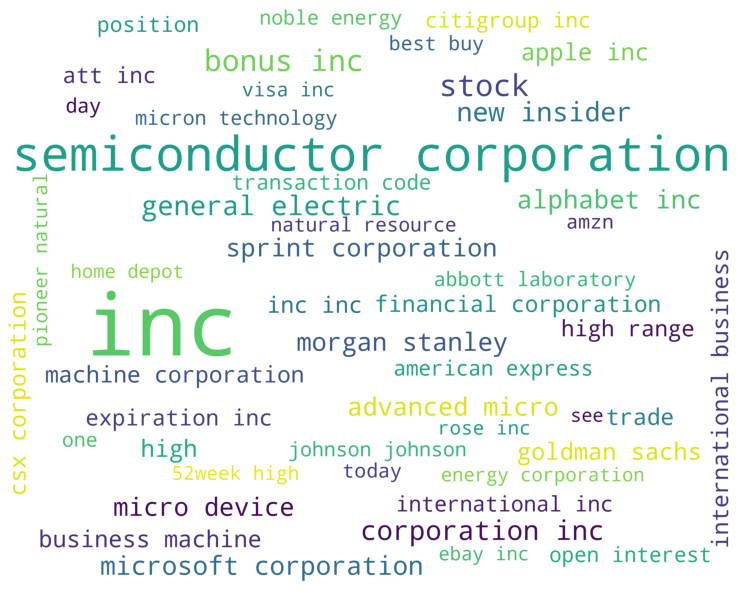

In [67]:
wordcloud_draw(positive_df.text, 'white')
# We see more company names mentioned in this sub group of tweets

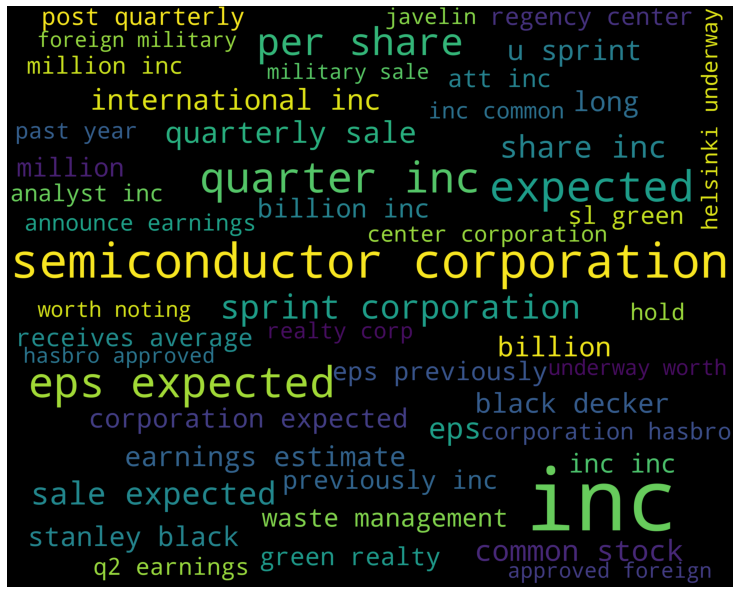

In [68]:
wordcloud_draw(negative_df.text)
# words related to expected sales and earnings are more commonly spotted in the sub group of tweets that have negative sentiments

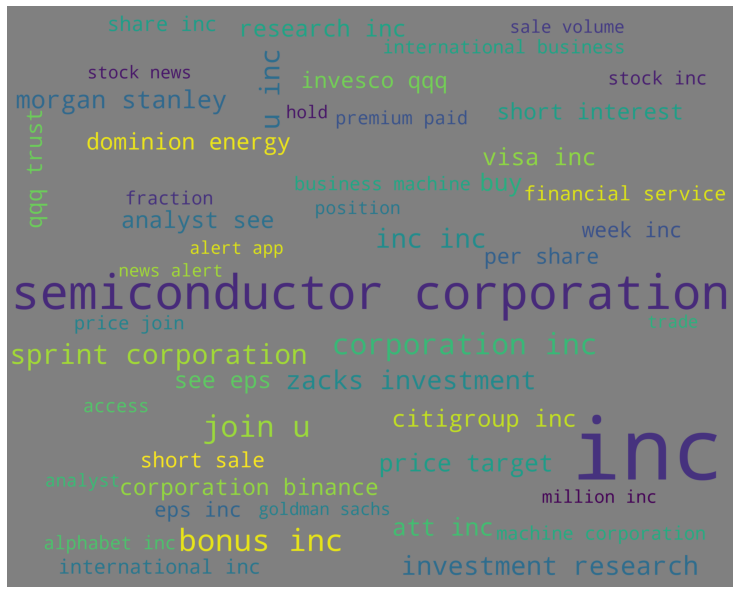

In [69]:
wordcloud_draw(neutral_df.text, 'grey')
#words relating to analyst, financial professionals and instruments are more commonly seen.

In [70]:
# Overall we can see some slight difference in the type of common words that are seen in the 3 sub different group of words.
# This suggest that even if we do a unigram and/or bigram model we can possible get some predictive power with 
# simple machine learning methods. However we are going to skip simple machine learning methods since they can't capture much
# contextual information and also basic deep learning methods like RNN and LSTM due to vanishing/exploding gradient issues.
# Let's check out the trigram combination next

In [71]:
def get_top_n_words(text,ngram,n=None): # ngram_range=(1, 1) or (2,2) or (3,3)
    vec = CountVectorizer(stop_words = 'english', ngram_range=ngram).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    common_words = words_freq[:n]
    df = pd.DataFrame(common_words,columns=['word','count'])
    return df

In [72]:
df_show = get_top_n_words(positive_df['text'],(3,3), 20)
df_show.groupby('word').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams used with Positive Sentiment',color='green')

In [73]:
df_show = get_top_n_words(negative_df['text'],(3,3), 20)
df_show.groupby('word').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams used with Negative Sentiment',color='red')

In [74]:
df_show = get_top_n_words(neutral_df['text'],(3,3), 20)
df_show.groupby('word').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams used with Neutral Sentiment',color='grey')

In [75]:
#Now we investigate and see if the topics are also different for the 3 sub groups
def topic_modelling(X):
    count_vectorizer = CountVectorizer(stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", min_df = 0.05)
    count_vectorizer.fit(X)
    doc_word = count_vectorizer.transform(X).transpose()
    corpus = matutils.Sparse2Corpus(doc_word)
    id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
    lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=10, random_state = 123)
    return lda

In [76]:
lda = topic_modelling(positive_df.text)
lda.print_topics()
#topics related to new and high are words that are distinguished from the negative sentiments dataset.

2022-06-02 21:26:22,179 : INFO : using symmetric alpha at 0.2
2022-06-02 21:26:22,179 : INFO : using symmetric eta at 0.2
2022-06-02 21:26:22,180 : INFO : using serial LDA version on this node
2022-06-02 21:26:22,180 : INFO : running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 8245 documents, updating model once every 2000 documents, evaluating perplexity every 8245 documents, iterating 50x with a convergence threshold of 0.001000
2022-06-02 21:26:22,185 : INFO : PROGRESS: pass 0, at document #2000/8245
2022-06-02 21:26:22,475 : INFO : merging changes from 2000 documents into a model of 8245 documents
2022-06-02 21:26:22,476 : INFO : topic #0 (0.200): 0.403*"hasbro" + 0.370*"energy" + 0.137*"stock" + 0.052*"new" + 0.015*"corporation" + 0.013*"international" + 0.005*"high" + 0.003*"semiconductor" + 0.002*"general"
2022-06-02 21:26:22,477 : INFO : topic #1 (0.200): 0.442*"high" + 0.255*"international" + 0.122*"corporation" + 0.110*"energy" + 0.056*"g

2022-06-02 21:26:23,298 : INFO : topic #4 (0.200): 0.594*"general" + 0.240*"corporation" + 0.156*"international" + 0.003*"stock" + 0.002*"energy" + 0.002*"new" + 0.002*"semiconductor" + 0.001*"high" + 0.000*"hasbro"
2022-06-02 21:26:23,298 : INFO : topic diff=0.493827, rho=0.404144
2022-06-02 21:26:23,303 : INFO : PROGRESS: pass 1, at document #4000/8245
2022-06-02 21:26:23,460 : INFO : merging changes from 2000 documents into a model of 8245 documents
2022-06-02 21:26:23,461 : INFO : topic #0 (0.200): 0.627*"energy" + 0.315*"hasbro" + 0.051*"stock" + 0.004*"new" + 0.002*"corporation" + 0.000*"international" + 0.000*"semiconductor" + 0.000*"high" + 0.000*"general"
2022-06-02 21:26:23,461 : INFO : topic #1 (0.200): 0.591*"high" + 0.343*"international" + 0.062*"corporation" + 0.003*"energy" + 0.001*"general" + 0.000*"semiconductor" + 0.000*"stock" + 0.000*"hasbro" + 0.000*"new"
2022-06-02 21:26:23,462 : INFO : topic #2 (0.200): 0.442*"stock" + 0.421*"new" + 0.121*"corporation" + 0.009*"s

2022-06-02 21:26:24,125 : INFO : topic diff=0.331527, rho=0.374700
2022-06-02 21:26:24,129 : INFO : PROGRESS: pass 2, at document #6000/8245
2022-06-02 21:26:24,257 : INFO : merging changes from 2000 documents into a model of 8245 documents
2022-06-02 21:26:24,258 : INFO : topic #0 (0.200): 0.637*"energy" + 0.348*"hasbro" + 0.012*"stock" + 0.001*"new" + 0.001*"corporation" + 0.000*"international" + 0.000*"semiconductor" + 0.000*"high" + 0.000*"general"
2022-06-02 21:26:24,259 : INFO : topic #1 (0.200): 0.629*"high" + 0.343*"international" + 0.027*"corporation" + 0.000*"energy" + 0.000*"general" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"new" + 0.000*"hasbro"
2022-06-02 21:26:24,259 : INFO : topic #2 (0.200): 0.484*"new" + 0.480*"stock" + 0.034*"corporation" + 0.002*"semiconductor" + 0.001*"international" + 0.000*"high" + 0.000*"hasbro" + 0.000*"general" + 0.000*"energy"
2022-06-02 21:26:24,260 : INFO : topic #3 (0.200): 0.782*"corporation" + 0.214*"semiconductor" + 0.002*"interna

2022-06-02 21:26:25,022 : INFO : merging changes from 2000 documents into a model of 8245 documents
2022-06-02 21:26:25,022 : INFO : topic #0 (0.200): 0.603*"energy" + 0.393*"hasbro" + 0.003*"stock" + 0.000*"new" + 0.000*"corporation" + 0.000*"international" + 0.000*"semiconductor" + 0.000*"high" + 0.000*"general"
2022-06-02 21:26:25,023 : INFO : topic #1 (0.200): 0.649*"high" + 0.338*"international" + 0.012*"corporation" + 0.000*"energy" + 0.000*"general" + 0.000*"new" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"hasbro"
2022-06-02 21:26:25,024 : INFO : topic #2 (0.200): 0.526*"new" + 0.464*"stock" + 0.009*"corporation" + 0.000*"semiconductor" + 0.000*"international" + 0.000*"high" + 0.000*"hasbro" + 0.000*"energy" + 0.000*"general"
2022-06-02 21:26:25,024 : INFO : topic #3 (0.200): 0.775*"corporation" + 0.224*"semiconductor" + 0.000*"international" + 0.000*"stock" + 0.000*"energy" + 0.000*"new" + 0.000*"high" + 0.000*"general" + 0.000*"hasbro"
2022-06-02 21:26:25,025 : INFO : top

2022-06-02 21:26:25,710 : INFO : merging changes from 245 documents into a model of 8245 documents
2022-06-02 21:26:25,711 : INFO : topic #0 (0.200): 0.603*"energy" + 0.395*"hasbro" + 0.001*"stock" + 0.000*"corporation" + 0.000*"new" + 0.000*"semiconductor" + 0.000*"international" + 0.000*"high" + 0.000*"general"
2022-06-02 21:26:25,711 : INFO : topic #1 (0.200): 0.505*"high" + 0.488*"international" + 0.006*"corporation" + 0.000*"energy" + 0.000*"stock" + 0.000*"new" + 0.000*"hasbro" + 0.000*"semiconductor" + 0.000*"general"
2022-06-02 21:26:25,712 : INFO : topic #2 (0.200): 0.522*"new" + 0.474*"stock" + 0.003*"corporation" + 0.000*"semiconductor" + 0.000*"international" + 0.000*"hasbro" + 0.000*"high" + 0.000*"energy" + 0.000*"general"
2022-06-02 21:26:25,712 : INFO : topic #3 (0.200): 0.778*"corporation" + 0.221*"semiconductor" + 0.000*"international" + 0.000*"stock" + 0.000*"energy" + 0.000*"new" + 0.000*"high" + 0.000*"general" + 0.000*"hasbro"
2022-06-02 21:26:25,713 : INFO : topi

2022-06-02 21:26:26,488 : INFO : topic #1 (0.200): 0.602*"high" + 0.395*"international" + 0.002*"corporation" + 0.000*"stock" + 0.000*"new" + 0.000*"energy" + 0.000*"semiconductor" + 0.000*"hasbro" + 0.000*"general"
2022-06-02 21:26:26,488 : INFO : topic #2 (0.200): 0.517*"stock" + 0.481*"new" + 0.001*"corporation" + 0.000*"semiconductor" + 0.000*"international" + 0.000*"hasbro" + 0.000*"high" + 0.000*"energy" + 0.000*"general"
2022-06-02 21:26:26,489 : INFO : topic #3 (0.200): 0.798*"corporation" + 0.202*"semiconductor" + 0.000*"international" + 0.000*"stock" + 0.000*"energy" + 0.000*"new" + 0.000*"high" + 0.000*"general" + 0.000*"hasbro"
2022-06-02 21:26:26,489 : INFO : topic #4 (0.200): 0.507*"general" + 0.305*"corporation" + 0.187*"international" + 0.000*"energy" + 0.000*"semiconductor" + 0.000*"stock" + 0.000*"new" + 0.000*"high" + 0.000*"hasbro"
2022-06-02 21:26:26,490 : INFO : topic diff=0.175275, rho=0.299846
2022-06-02 21:26:26,494 : INFO : PROGRESS: pass 6, at document #4000/

2022-06-02 21:26:27,311 : INFO : topic #2 (0.200): 0.523*"stock" + 0.476*"new" + 0.000*"corporation" + 0.000*"semiconductor" + 0.000*"international" + 0.000*"hasbro" + 0.000*"high" + 0.000*"energy" + 0.000*"general"
2022-06-02 21:26:27,312 : INFO : topic #3 (0.200): 0.807*"corporation" + 0.192*"semiconductor" + 0.000*"international" + 0.000*"stock" + 0.000*"new" + 0.000*"energy" + 0.000*"high" + 0.000*"hasbro" + 0.000*"general"
2022-06-02 21:26:27,312 : INFO : topic #4 (0.200): 0.429*"general" + 0.359*"corporation" + 0.211*"international" + 0.000*"energy" + 0.000*"semiconductor" + 0.000*"stock" + 0.000*"new" + 0.000*"high" + 0.000*"hasbro"
2022-06-02 21:26:27,313 : INFO : topic diff=0.086419, rho=0.287213
2022-06-02 21:26:27,317 : INFO : PROGRESS: pass 7, at document #6000/8245
2022-06-02 21:26:27,455 : INFO : merging changes from 2000 documents into a model of 8245 documents
2022-06-02 21:26:27,455 : INFO : topic #0 (0.200): 0.647*"energy" + 0.352*"hasbro" + 0.000*"stock" + 0.000*"cor

2022-06-02 21:26:28,158 : INFO : topic #3 (0.200): 0.772*"corporation" + 0.228*"semiconductor" + 0.000*"international" + 0.000*"new" + 0.000*"stock" + 0.000*"energy" + 0.000*"high" + 0.000*"hasbro" + 0.000*"general"
2022-06-02 21:26:28,158 : INFO : topic #4 (0.200): 0.434*"corporation" + 0.305*"international" + 0.260*"general" + 0.000*"stock" + 0.000*"energy" + 0.000*"semiconductor" + 0.000*"new" + 0.000*"hasbro" + 0.000*"high"
2022-06-02 21:26:28,159 : INFO : topic diff=0.078028, rho=0.276053
2022-06-02 21:26:28,163 : INFO : PROGRESS: pass 8, at document #8000/8245
2022-06-02 21:26:28,304 : INFO : merging changes from 2000 documents into a model of 8245 documents
2022-06-02 21:26:28,304 : INFO : topic #0 (0.200): 0.614*"energy" + 0.384*"hasbro" + 0.000*"stock" + 0.000*"corporation" + 0.000*"new" + 0.000*"semiconductor" + 0.000*"international" + 0.000*"high" + 0.000*"general"
2022-06-02 21:26:28,305 : INFO : topic #1 (0.200): 0.900*"high" + 0.098*"international" + 0.000*"corporation" +

2022-06-02 21:26:28,981 : INFO : topic #4 (0.200): 0.450*"corporation" + 0.307*"international" + 0.243*"general" + 0.000*"stock" + 0.000*"energy" + 0.000*"semiconductor" + 0.000*"new" + 0.000*"hasbro" + 0.000*"high"
2022-06-02 21:26:28,982 : INFO : topic diff=0.061030, rho=0.266100
2022-06-02 21:26:29,017 : INFO : -1.966 per-word bound, 3.9 perplexity estimate based on a held-out corpus of 245 documents with 282 words
2022-06-02 21:26:29,017 : INFO : PROGRESS: pass 9, at document #8245/8245
2022-06-02 21:26:29,038 : INFO : merging changes from 245 documents into a model of 8245 documents
2022-06-02 21:26:29,039 : INFO : topic #0 (0.200): 0.611*"energy" + 0.387*"hasbro" + 0.000*"corporation" + 0.000*"stock" + 0.000*"new" + 0.000*"semiconductor" + 0.000*"international" + 0.000*"high" + 0.000*"general"
2022-06-02 21:26:29,039 : INFO : topic #1 (0.200): 0.974*"high" + 0.024*"international" + 0.000*"corporation" + 0.000*"new" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*

[(0,
  '0.611*"energy" + 0.387*"hasbro" + 0.000*"corporation" + 0.000*"stock" + 0.000*"new" + 0.000*"semiconductor" + 0.000*"international" + 0.000*"high" + 0.000*"general"'),
 (1,
  '0.974*"high" + 0.024*"international" + 0.000*"corporation" + 0.000*"new" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*"hasbro" + 0.000*"general"'),
 (2,
  '0.519*"new" + 0.480*"stock" + 0.000*"corporation" + 0.000*"semiconductor" + 0.000*"hasbro" + 0.000*"international" + 0.000*"high" + 0.000*"energy" + 0.000*"general"'),
 (3,
  '0.748*"corporation" + 0.251*"semiconductor" + 0.000*"new" + 0.000*"stock" + 0.000*"energy" + 0.000*"international" + 0.000*"hasbro" + 0.000*"high" + 0.000*"general"'),
 (4,
  '0.458*"corporation" + 0.344*"international" + 0.197*"general" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*"new" + 0.000*"hasbro" + 0.000*"high"')]

In [77]:
lda = topic_modelling(negative_df.text)
lda.print_topics()
# Topics for the negative sentiment also revolves around expected sales, earnings, eps etc.

2022-06-02 21:26:29,146 : INFO : using symmetric alpha at 0.2
2022-06-02 21:26:29,147 : INFO : using symmetric eta at 0.2
2022-06-02 21:26:29,148 : INFO : using serial LDA version on this node
2022-06-02 21:26:29,149 : INFO : running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 3448 documents, updating model once every 2000 documents, evaluating perplexity every 3448 documents, iterating 50x with a convergence threshold of 0.001000
2022-06-02 21:26:29,154 : INFO : PROGRESS: pass 0, at document #2000/3448
2022-06-02 21:26:29,515 : INFO : merging changes from 2000 documents into a model of 3448 documents
2022-06-02 21:26:29,515 : INFO : topic #0 (0.200): 0.205*"corp" + 0.176*"corporation" + 0.140*"earnings" + 0.104*"expected" + 0.096*"share" + 0.084*"semiconductor" + 0.065*"stock" + 0.035*"international" + 0.027*"quarter" + 0.025*"million"
2022-06-02 21:26:29,516 : INFO : topic #1 (0.200): 0.154*"expected" + 0.146*"international" + 0.119*"sale" + 0.11

2022-06-02 21:26:31,017 : INFO : topic #1 (0.200): 0.195*"international" + 0.168*"sale" + 0.162*"expected" + 0.160*"stock" + 0.121*"billion" + 0.091*"million" + 0.083*"quarter" + 0.014*"corporation" + 0.002*"semiconductor" + 0.001*"eps"
2022-06-02 21:26:31,018 : INFO : topic #2 (0.200): 0.409*"hasbro" + 0.266*"corporation" + 0.154*"sale" + 0.049*"earnings" + 0.033*"share" + 0.024*"international" + 0.019*"expected" + 0.013*"semiconductor" + 0.012*"eps" + 0.007*"billion"
2022-06-02 21:26:31,018 : INFO : topic #3 (0.200): 0.508*"eps" + 0.386*"expected" + 0.054*"quarter" + 0.018*"corporation" + 0.015*"hasbro" + 0.006*"stock" + 0.004*"million" + 0.003*"earnings" + 0.002*"corp" + 0.002*"share"
2022-06-02 21:26:31,019 : INFO : topic #4 (0.200): 0.775*"corporation" + 0.190*"semiconductor" + 0.011*"expected" + 0.007*"stock" + 0.004*"eps" + 0.004*"corp" + 0.002*"sale" + 0.002*"million" + 0.001*"share" + 0.001*"international"
2022-06-02 21:26:31,019 : INFO : topic diff=0.359885, rho=0.460092
2022

2022-06-02 21:26:32,155 : INFO : topic diff=0.310186, rho=0.359815
2022-06-02 21:26:32,339 : INFO : -2.371 per-word bound, 5.2 perplexity estimate based on a held-out corpus of 1448 documents with 2501 words
2022-06-02 21:26:32,339 : INFO : PROGRESS: pass 5, at document #3448/3448
2022-06-02 21:26:32,444 : INFO : merging changes from 1448 documents into a model of 3448 documents
2022-06-02 21:26:32,444 : INFO : topic #0 (0.200): 0.328*"earnings" + 0.253*"share" + 0.166*"corp" + 0.147*"expected" + 0.045*"quarter" + 0.035*"corporation" + 0.022*"stock" + 0.002*"international" + 0.001*"semiconductor" + 0.000*"million"
2022-06-02 21:26:32,445 : INFO : topic #1 (0.200): 0.202*"international" + 0.173*"stock" + 0.164*"sale" + 0.160*"expected" + 0.120*"billion" + 0.094*"million" + 0.083*"quarter" + 0.002*"corporation" + 0.000*"semiconductor" + 0.000*"eps"
2022-06-02 21:26:32,446 : INFO : topic #2 (0.200): 0.539*"hasbro" + 0.244*"corporation" + 0.190*"sale" + 0.007*"earnings" + 0.007*"share" + 0

2022-06-02 21:26:33,513 : INFO : topic #3 (0.200): 0.527*"eps" + 0.413*"expected" + 0.056*"quarter" + 0.001*"corporation" + 0.000*"hasbro" + 0.000*"stock" + 0.000*"earnings" + 0.000*"million" + 0.000*"corp" + 0.000*"share"
2022-06-02 21:26:33,514 : INFO : topic #4 (0.200): 0.825*"corporation" + 0.170*"semiconductor" + 0.002*"stock" + 0.000*"expected" + 0.000*"corp" + 0.000*"eps" + 0.000*"sale" + 0.000*"international" + 0.000*"million" + 0.000*"share"
2022-06-02 21:26:33,514 : INFO : topic diff=0.189466, rho=0.305367
2022-06-02 21:26:33,691 : INFO : -2.360 per-word bound, 5.1 perplexity estimate based on a held-out corpus of 1448 documents with 2501 words
2022-06-02 21:26:33,692 : INFO : PROGRESS: pass 8, at document #3448/3448
2022-06-02 21:26:33,793 : INFO : merging changes from 1448 documents into a model of 3448 documents
2022-06-02 21:26:33,794 : INFO : topic #0 (0.200): 0.340*"earnings" + 0.262*"share" + 0.172*"corp" + 0.153*"expected" + 0.047*"quarter" + 0.014*"corporation" + 0.0

[(0,
  '0.342*"earnings" + 0.264*"share" + 0.173*"corp" + 0.154*"expected" + 0.048*"quarter" + 0.011*"corporation" + 0.006*"stock" + 0.000*"international" + 0.000*"semiconductor" + 0.000*"million"'),
 (1,
  '0.201*"international" + 0.184*"stock" + 0.161*"sale" + 0.158*"expected" + 0.118*"billion" + 0.094*"million" + 0.083*"quarter" + 0.000*"corporation" + 0.000*"semiconductor" + 0.000*"eps"'),
 (2,
  '0.555*"hasbro" + 0.242*"corporation" + 0.197*"sale" + 0.001*"share" + 0.001*"earnings" + 0.001*"international" + 0.001*"semiconductor" + 0.000*"expected" + 0.000*"eps" + 0.000*"billion"'),
 (3,
  '0.531*"eps" + 0.412*"expected" + 0.054*"quarter" + 0.001*"corporation" + 0.000*"hasbro" + 0.000*"stock" + 0.000*"earnings" + 0.000*"million" + 0.000*"corp" + 0.000*"share"'),
 (4,
  '0.815*"corporation" + 0.182*"semiconductor" + 0.002*"stock" + 0.000*"expected" + 0.000*"corp" + 0.000*"eps" + 0.000*"international" + 0.000*"sale" + 0.000*"million" + 0.000*"share"')]

In [78]:
lda = topic_modelling(neutral_df.text)
lda.print_topics()

2022-06-02 21:26:34,628 : INFO : using symmetric alpha at 0.2
2022-06-02 21:26:34,628 : INFO : using symmetric eta at 0.2
2022-06-02 21:26:34,628 : INFO : using serial LDA version on this node
2022-06-02 21:26:34,629 : INFO : running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 16569 documents, updating model once every 2000 documents, evaluating perplexity every 16569 documents, iterating 50x with a convergence threshold of 0.001000
2022-06-02 21:26:34,633 : INFO : PROGRESS: pass 0, at document #2000/16569
2022-06-02 21:26:34,905 : INFO : merging changes from 2000 documents into a model of 16569 documents
2022-06-02 21:26:34,905 : INFO : topic #0 (0.200): 0.486*"corporation" + 0.366*"energy" + 0.043*"semiconductor" + 0.034*"stock" + 0.028*"analyst" + 0.021*"price" + 0.012*"share" + 0.008*"earnings" + 0.002*"international"
2022-06-02 21:26:34,906 : INFO : topic #1 (0.200): 0.491*"corporation" + 0.228*"international" + 0.161*"price" + 0.050*"earnings

2022-06-02 21:26:35,860 : INFO : topic #4 (0.200): 0.430*"corporation" + 0.298*"semiconductor" + 0.186*"earnings" + 0.085*"share" + 0.000*"stock" + 0.000*"price" + 0.000*"analyst" + 0.000*"international" + 0.000*"energy"
2022-06-02 21:26:35,860 : INFO : topic diff=0.353256, rho=0.408248
2022-06-02 21:26:35,864 : INFO : PROGRESS: pass 0, at document #14000/16569
2022-06-02 21:26:36,021 : INFO : merging changes from 2000 documents into a model of 16569 documents
2022-06-02 21:26:36,022 : INFO : topic #0 (0.200): 0.600*"energy" + 0.379*"corporation" + 0.007*"semiconductor" + 0.005*"price" + 0.004*"analyst" + 0.003*"stock" + 0.001*"share" + 0.001*"earnings" + 0.000*"international"
2022-06-02 21:26:36,023 : INFO : topic #1 (0.200): 0.628*"corporation" + 0.193*"price" + 0.174*"international" + 0.003*"share" + 0.001*"earnings" + 0.001*"analyst" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*"stock"
2022-06-02 21:26:36,024 : INFO : topic #2 (0.200): 0.722*"stock" + 0.155*"corporation" + 0.09

2022-06-02 21:26:36,827 : INFO : topic #4 (0.200): 0.448*"corporation" + 0.345*"semiconductor" + 0.131*"earnings" + 0.076*"share" + 0.000*"stock" + 0.000*"price" + 0.000*"analyst" + 0.000*"international" + 0.000*"energy"
2022-06-02 21:26:36,828 : INFO : topic diff=0.257595, rho=0.311823
2022-06-02 21:26:36,832 : INFO : PROGRESS: pass 1, at document #8000/16569
2022-06-02 21:26:36,985 : INFO : merging changes from 2000 documents into a model of 16569 documents
2022-06-02 21:26:36,985 : INFO : topic #0 (0.200): 0.731*"energy" + 0.266*"corporation" + 0.001*"price" + 0.001*"semiconductor" + 0.000*"analyst" + 0.000*"stock" + 0.000*"share" + 0.000*"earnings" + 0.000*"international"
2022-06-02 21:26:36,986 : INFO : topic #1 (0.200): 0.669*"corporation" + 0.174*"international" + 0.156*"price" + 0.000*"share" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*"stock"
2022-06-02 21:26:36,986 : INFO : topic #2 (0.200): 0.724*"stock" + 0.216*"share" + 0.051*"corp

2022-06-02 21:26:37,759 : INFO : topic #4 (0.200): 0.466*"corporation" + 0.381*"semiconductor" + 0.118*"earnings" + 0.035*"share" + 0.000*"stock" + 0.000*"price" + 0.000*"analyst" + 0.000*"international" + 0.000*"energy"
2022-06-02 21:26:37,760 : INFO : topic diff=0.182885, rho=0.311823
2022-06-02 21:26:37,763 : INFO : PROGRESS: pass 2, at document #2000/16569
2022-06-02 21:26:37,909 : INFO : merging changes from 2000 documents into a model of 16569 documents
2022-06-02 21:26:37,910 : INFO : topic #0 (0.200): 0.733*"energy" + 0.266*"corporation" + 0.000*"price" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"stock" + 0.000*"share" + 0.000*"earnings" + 0.000*"international"
2022-06-02 21:26:37,910 : INFO : topic #1 (0.200): 0.660*"corporation" + 0.196*"international" + 0.144*"price" + 0.000*"share" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*"stock"
2022-06-02 21:26:37,911 : INFO : topic #2 (0.200): 0.644*"stock" + 0.337*"share" + 0.016*"corp

2022-06-02 21:26:38,696 : INFO : topic diff=0.123377, rho=0.297686
2022-06-02 21:26:38,700 : INFO : PROGRESS: pass 2, at document #14000/16569
2022-06-02 21:26:38,845 : INFO : merging changes from 2000 documents into a model of 16569 documents
2022-06-02 21:26:38,845 : INFO : topic #0 (0.200): 0.786*"energy" + 0.213*"corporation" + 0.000*"price" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"stock" + 0.000*"share" + 0.000*"earnings" + 0.000*"international"
2022-06-02 21:26:38,846 : INFO : topic #1 (0.200): 0.675*"corporation" + 0.167*"price" + 0.157*"international" + 0.000*"share" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"semiconductor" + 0.000*"stock" + 0.000*"energy"
2022-06-02 21:26:38,846 : INFO : topic #2 (0.200): 0.617*"stock" + 0.377*"share" + 0.005*"corporation" + 0.001*"price" + 0.000*"semiconductor" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"international" + 0.000*"energy"
2022-06-02 21:26:38,847 : INFO : topic #3 (0.200): 0.985*"analyst" + 0.013*"corporation" + 0.

2022-06-02 21:26:39,603 : INFO : topic diff=0.091294, rho=0.285313
2022-06-02 21:26:39,607 : INFO : PROGRESS: pass 3, at document #8000/16569
2022-06-02 21:26:39,752 : INFO : merging changes from 2000 documents into a model of 16569 documents
2022-06-02 21:26:39,753 : INFO : topic #0 (0.200): 0.803*"energy" + 0.196*"corporation" + 0.000*"price" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"stock" + 0.000*"earnings" + 0.000*"share" + 0.000*"international"
2022-06-02 21:26:39,753 : INFO : topic #1 (0.200): 0.686*"corporation" + 0.166*"international" + 0.149*"price" + 0.000*"share" + 0.000*"earnings" + 0.000*"analyst" + 0.000*"semiconductor" + 0.000*"stock" + 0.000*"energy"
2022-06-02 21:26:39,754 : INFO : topic #2 (0.200): 0.609*"stock" + 0.388*"share" + 0.002*"corporation" + 0.000*"price" + 0.000*"semiconductor" + 0.000*"earnings" + 0.000*"international" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:39,755 : INFO : topic #3 (0.200): 0.995*"analyst" + 0.004*"corporation" + 0.0

2022-06-02 21:26:40,500 : INFO : topic diff=0.112104, rho=0.285313
2022-06-02 21:26:40,505 : INFO : PROGRESS: pass 4, at document #2000/16569
2022-06-02 21:26:40,653 : INFO : merging changes from 2000 documents into a model of 16569 documents
2022-06-02 21:26:40,654 : INFO : topic #0 (0.200): 0.792*"energy" + 0.208*"corporation" + 0.000*"price" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"stock" + 0.000*"earnings" + 0.000*"share" + 0.000*"international"
2022-06-02 21:26:40,654 : INFO : topic #1 (0.200): 0.669*"corporation" + 0.189*"international" + 0.142*"price" + 0.000*"earnings" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"stock" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:40,655 : INFO : topic #2 (0.200): 0.577*"stock" + 0.422*"share" + 0.001*"corporation" + 0.000*"price" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"international" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:40,656 : INFO : topic #3 (0.200): 0.997*"analyst" + 0.001*"corporation" + 0.0

2022-06-02 21:26:41,574 : INFO : merging changes from 2000 documents into a model of 16569 documents
2022-06-02 21:26:41,575 : INFO : topic #0 (0.200): 0.815*"energy" + 0.184*"corporation" + 0.000*"price" + 0.000*"semiconductor" + 0.000*"earnings" + 0.000*"share" + 0.000*"analyst" + 0.000*"stock" + 0.000*"international"
2022-06-02 21:26:41,575 : INFO : topic #1 (0.200): 0.678*"corporation" + 0.165*"price" + 0.157*"international" + 0.000*"earnings" + 0.000*"stock" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:41,576 : INFO : topic #2 (0.200): 0.600*"stock" + 0.399*"share" + 0.000*"corporation" + 0.000*"price" + 0.000*"earnings" + 0.000*"international" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:41,576 : INFO : topic #3 (0.200): 0.998*"analyst" + 0.001*"corporation" + 0.000*"earnings" + 0.000*"price" + 0.000*"international" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*"stock"
2022-06-02 21:2

2022-06-02 21:26:42,579 : INFO : merging changes from 2000 documents into a model of 16569 documents
2022-06-02 21:26:42,580 : INFO : topic #0 (0.200): 0.821*"energy" + 0.178*"corporation" + 0.000*"price" + 0.000*"earnings" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"share" + 0.000*"international"
2022-06-02 21:26:42,580 : INFO : topic #1 (0.200): 0.687*"corporation" + 0.165*"international" + 0.148*"price" + 0.000*"stock" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"share" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:42,580 : INFO : topic #2 (0.200): 0.605*"stock" + 0.395*"share" + 0.000*"corporation" + 0.000*"price" + 0.000*"earnings" + 0.000*"international" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:42,581 : INFO : topic #3 (0.200): 0.999*"analyst" + 0.000*"corporation" + 0.000*"earnings" + 0.000*"price" + 0.000*"international" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*"stock"
2022-06-02 21:2

2022-06-02 21:26:43,467 : INFO : merging changes from 2000 documents into a model of 16569 documents
2022-06-02 21:26:43,468 : INFO : topic #0 (0.200): 0.801*"energy" + 0.199*"corporation" + 0.000*"price" + 0.000*"semiconductor" + 0.000*"earnings" + 0.000*"stock" + 0.000*"analyst" + 0.000*"share" + 0.000*"international"
2022-06-02 21:26:43,468 : INFO : topic #1 (0.200): 0.670*"corporation" + 0.187*"international" + 0.143*"price" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"stock" + 0.000*"share" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:43,469 : INFO : topic #2 (0.200): 0.577*"stock" + 0.422*"share" + 0.000*"corporation" + 0.000*"earnings" + 0.000*"price" + 0.000*"international" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:43,470 : INFO : topic #3 (0.200): 0.999*"analyst" + 0.000*"corporation" + 0.000*"earnings" + 0.000*"price" + 0.000*"international" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*"stock"
2022-06-02 21:2

2022-06-02 21:26:44,399 : INFO : topic #1 (0.200): 0.678*"corporation" + 0.164*"price" + 0.157*"international" + 0.000*"earnings" + 0.000*"stock" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:44,399 : INFO : topic #2 (0.200): 0.600*"stock" + 0.400*"share" + 0.000*"corporation" + 0.000*"earnings" + 0.000*"price" + 0.000*"international" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:44,400 : INFO : topic #3 (0.200): 0.999*"analyst" + 0.000*"corporation" + 0.000*"earnings" + 0.000*"price" + 0.000*"international" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*"stock"
2022-06-02 21:26:44,401 : INFO : topic #4 (0.200): 0.479*"corporation" + 0.351*"semiconductor" + 0.170*"earnings" + 0.000*"share" + 0.000*"international" + 0.000*"price" + 0.000*"stock" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:44,401 : INFO : topic diff=0.047928, rho=0.255785
2022-06-02 21:26:44,406 : INFO : PROGRESS: pass 6

2022-06-02 21:26:45,314 : INFO : topic #1 (0.200): 0.686*"corporation" + 0.166*"international" + 0.148*"price" + 0.000*"stock" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"share" + 0.000*"energy"
2022-06-02 21:26:45,315 : INFO : topic #2 (0.200): 0.604*"stock" + 0.396*"share" + 0.000*"earnings" + 0.000*"price" + 0.000*"corporation" + 0.000*"international" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:45,315 : INFO : topic #3 (0.200): 0.999*"analyst" + 0.000*"earnings" + 0.000*"price" + 0.000*"corporation" + 0.000*"international" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*"stock"
2022-06-02 21:26:45,316 : INFO : topic #4 (0.200): 0.482*"corporation" + 0.361*"semiconductor" + 0.157*"earnings" + 0.000*"share" + 0.000*"international" + 0.000*"price" + 0.000*"stock" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:45,316 : INFO : topic diff=0.023241, rho=0.247807
2022-06-02 21:26:45,320 : INFO : PROGRESS: pass 7

2022-06-02 21:26:46,216 : INFO : topic #1 (0.200): 0.671*"corporation" + 0.185*"international" + 0.144*"price" + 0.000*"earnings" + 0.000*"stock" + 0.000*"semiconductor" + 0.000*"share" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:46,217 : INFO : topic #2 (0.200): 0.578*"stock" + 0.422*"share" + 0.000*"earnings" + 0.000*"corporation" + 0.000*"price" + 0.000*"international" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:46,217 : INFO : topic #3 (0.200): 0.999*"analyst" + 0.000*"earnings" + 0.000*"price" + 0.000*"corporation" + 0.000*"international" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*"stock"
2022-06-02 21:26:46,218 : INFO : topic #4 (0.200): 0.487*"corporation" + 0.381*"semiconductor" + 0.132*"earnings" + 0.000*"share" + 0.000*"international" + 0.000*"price" + 0.000*"analyst" + 0.000*"stock" + 0.000*"energy"
2022-06-02 21:26:46,219 : INFO : topic diff=0.091820, rho=0.240531
2022-06-02 21:26:46,223 : INFO : PROGRESS: pass 8

2022-06-02 21:26:47,151 : INFO : topic #2 (0.200): 0.600*"stock" + 0.400*"share" + 0.000*"earnings" + 0.000*"price" + 0.000*"corporation" + 0.000*"international" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:47,151 : INFO : topic #3 (0.200): 0.999*"analyst" + 0.000*"earnings" + 0.000*"price" + 0.000*"corporation" + 0.000*"international" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*"stock"
2022-06-02 21:26:47,152 : INFO : topic #4 (0.200): 0.480*"corporation" + 0.351*"semiconductor" + 0.169*"earnings" + 0.000*"share" + 0.000*"international" + 0.000*"price" + 0.000*"stock" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:47,152 : INFO : topic diff=0.046479, rho=0.240531
2022-06-02 21:26:47,156 : INFO : PROGRESS: pass 8, at document #16000/16569
2022-06-02 21:26:47,305 : INFO : merging changes from 2000 documents into a model of 16569 documents
2022-06-02 21:26:47,306 : INFO : topic #0 (0.200): 0.766*"energy" + 0.233*"corporation" + 0.0

2022-06-02 21:26:48,060 : INFO : topic #2 (0.200): 0.603*"stock" + 0.396*"share" + 0.000*"earnings" + 0.000*"price" + 0.000*"corporation" + 0.000*"international" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:48,060 : INFO : topic #3 (0.200): 0.999*"analyst" + 0.000*"earnings" + 0.000*"price" + 0.000*"corporation" + 0.000*"international" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"energy" + 0.000*"stock"
2022-06-02 21:26:48,061 : INFO : topic #4 (0.200): 0.482*"corporation" + 0.361*"semiconductor" + 0.156*"earnings" + 0.000*"share" + 0.000*"international" + 0.000*"price" + 0.000*"stock" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:48,061 : INFO : topic diff=0.021056, rho=0.233861
2022-06-02 21:26:48,066 : INFO : PROGRESS: pass 9, at document #10000/16569
2022-06-02 21:26:48,208 : INFO : merging changes from 2000 documents into a model of 16569 documents
2022-06-02 21:26:48,209 : INFO : topic #0 (0.200): 0.817*"energy" + 0.183*"corporation" + 0.0

2022-06-02 21:26:48,819 : INFO : topic #2 (0.200): 0.557*"stock" + 0.442*"share" + 0.000*"earnings" + 0.000*"corporation" + 0.000*"price" + 0.000*"international" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"energy"
2022-06-02 21:26:48,819 : INFO : topic #3 (0.200): 0.998*"analyst" + 0.000*"earnings" + 0.000*"price" + 0.000*"corporation" + 0.000*"international" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"stock" + 0.000*"energy"
2022-06-02 21:26:48,820 : INFO : topic #4 (0.200): 0.483*"corporation" + 0.386*"semiconductor" + 0.130*"earnings" + 0.000*"share" + 0.000*"international" + 0.000*"price" + 0.000*"analyst" + 0.000*"stock" + 0.000*"energy"


[(0,
  '0.773*"energy" + 0.226*"corporation" + 0.000*"price" + 0.000*"semiconductor" + 0.000*"stock" + 0.000*"earnings" + 0.000*"share" + 0.000*"analyst" + 0.000*"international"'),
 (1,
  '0.668*"corporation" + 0.177*"international" + 0.154*"price" + 0.000*"earnings" + 0.000*"semiconductor" + 0.000*"stock" + 0.000*"share" + 0.000*"analyst" + 0.000*"energy"'),
 (2,
  '0.557*"stock" + 0.442*"share" + 0.000*"earnings" + 0.000*"corporation" + 0.000*"price" + 0.000*"international" + 0.000*"semiconductor" + 0.000*"analyst" + 0.000*"energy"'),
 (3,
  '0.998*"analyst" + 0.000*"earnings" + 0.000*"price" + 0.000*"corporation" + 0.000*"international" + 0.000*"share" + 0.000*"semiconductor" + 0.000*"stock" + 0.000*"energy"'),
 (4,
  '0.483*"corporation" + 0.386*"semiconductor" + 0.130*"earnings" + 0.000*"share" + 0.000*"international" + 0.000*"price" + 0.000*"analyst" + 0.000*"stock" + 0.000*"energy"')]

In [79]:
#Random shuffle the neutral sentiments dataset and only take 50% sample
neutral_df = neutral_df.reindex(np.random.permutation(neutral_df.index))

In [80]:
neutral_df

,text,Polarity,Emotion,Label
19969,judge with u.sprint corporation . labor agency reject mcdonaldsprint corporation bid to settle f...,0.0,0,neutral
8176,watchlist this week ore anadarko petroleum corporation bkr popi ecp,0.0,0,neutral
19465,extra space storage extra space storage inc. stock rating reaffirmed by jefferies financial inc ...,0.0,0,neutral
15491,centene corp del centene corporation stake hasbro upped by tpgaxon management lp inc .. copli52k...,0.0,0,neutral
598,entergy co. entergy corporation receives consensus recommendation of buy from brokerage inc .. c...,0.0,0,neutral
...,...,...,...,...
9171,stock etf fund to review alphabetically kref krg krny krp k ksa ktos kura lamr lee leg lexea lgf...,0.0,0,neutral
14293,petri stop wasting your time trying to scramble between the algo on semiconductor corporation ou...,0.0,0,neutral
3031,out hub dang i humana inc. mr bud bam im morgan stanley franklin resource,0.0,0,neutral
10289,ross store inc ross store shifting institutional investor sentiment inc .. cot5b7ta2uh7,0.0,0,neutral


In [81]:
def sample_first_nrows(data, perc=0.5):
    import pandas as pd
    return data.head(int(len(data)*(perc)))

In [82]:
neutral_df_sampled = sample_first_nrows(neutral_df)

In [83]:
neutral_df_sampled

,text,Polarity,Emotion,Label
19969,judge with u.sprint corporation . labor agency reject mcdonaldsprint corporation bid to settle f...,0.0,0,neutral
8176,watchlist this week ore anadarko petroleum corporation bkr popi ecp,0.0,0,neutral
19465,extra space storage extra space storage inc. stock rating reaffirmed by jefferies financial inc ...,0.0,0,neutral
15491,centene corp del centene corporation stake hasbro upped by tpgaxon management lp inc .. copli52k...,0.0,0,neutral
598,entergy co. entergy corporation receives consensus recommendation of buy from brokerage inc .. c...,0.0,0,neutral
...,...,...,...,...
27515,netflix short selling le than 50 bottom inc .. co2owypznuxi,0.0,0,neutral
2711,analyst see 1.40 eps for microchip technology incorporated microchip technology incorporated inc...,0.0,0,neutral
4615,trader buy marriott international marriott international on semiconductor corporation weakness i...,0.0,0,neutral
7557,are analyst bullish about thermo fisher scientific inc. thermo fisher scientific inc. after last...,0.0,0,neutral


In [84]:
final_df = pd.concat([positive_df, negative_df, neutral_df_sampled])

In [85]:
final_df.Label.value_counts()

neutral     8284
positive    8245
negative    3448
Name: Label, dtype: int64

In [86]:
final_df["Words Per Tweet"] = final_df["text"].str.split().apply(len)
fig = px.box(final_df, x="Label", y="Words Per Tweet" ,color="Label")
fig.show()
# Seems like there a a few tweets that are outliers based on the length, we will set a threshold of max length to be 60

In [87]:
final_df = final_df[final_df['Words Per Tweet'] <= 60]

In [88]:
fig = px.box(final_df, x="Label", y="Words Per Tweet",color="Label")
fig.show()

In [89]:
#Random shuffle the neutral sentiments dataset and only take 50% sample
final_df = final_df.reindex(np.random.permutation(final_df.index))

In [90]:
model_df = final_df[['text','Emotion']]

In [91]:
# from transformers import AutoTokenizer
# model_ckpt = "distilbert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [92]:
# from transformers import DistilBertTokenizer
# distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [93]:
# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import cross_entropy
from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap


In [94]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [95]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [96]:
# Some of the common BERT tokens
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
token_df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
token_df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [97]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in model_df.text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


C:\Users\danie\anaconda3\envs\new-env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 0, 'Token count')

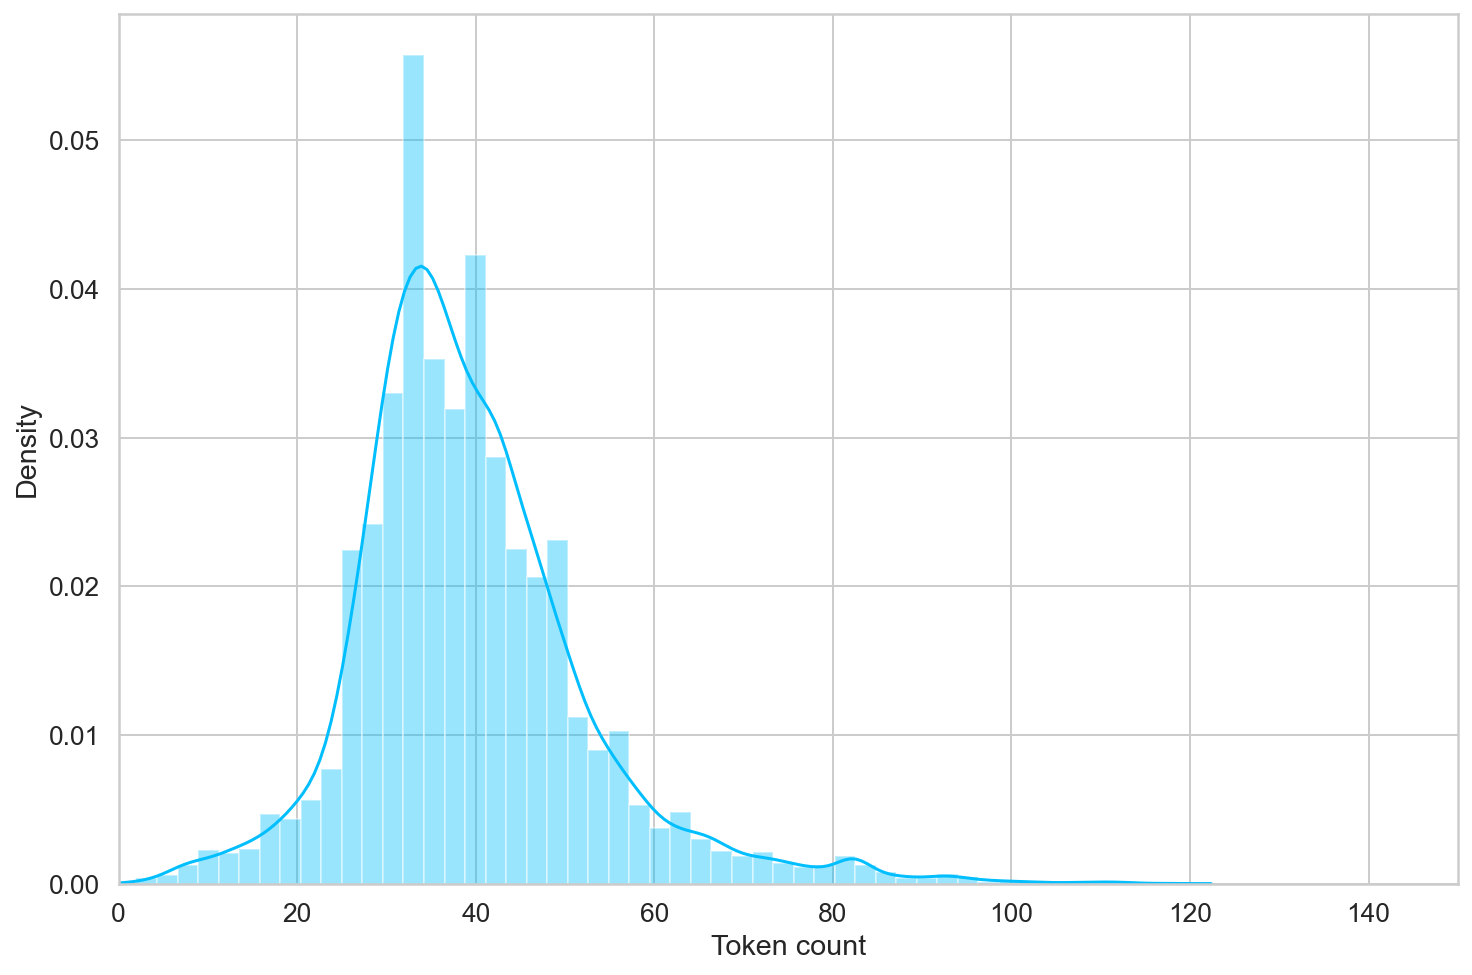

In [98]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 150]);
plt.xlabel('Token count')

In [99]:
# the datasets seem to taper off around 120 plus. We give some buffer here
MAX_LEN = 160

In [100]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [101]:
# We do a split of 80% training, 10% validation and 10% test set

df_train, df_test = train_test_split(model_df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(15976, 2) (1997, 2) (1998, 2)


In [102]:
# we set num_workers to 0 to prevent any potential crash or out of memory

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text.to_numpy(),
        targets=df.Emotion.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [103]:
# Create train, test and val data loaders, batch size kept at 16 to be safe from OOM
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [104]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


C:\Users\danie\anaconda3\envs\new-env\lib\site-packages\transformers\tokenization_utils_base.py:2211: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [105]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [106]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

In [107]:
length_of_class_names = model_df.Emotion.nunique()

In [108]:
# Instantiate the model and move to classifier
model = SentimentClassifier(length_of_class_names)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [109]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


In [110]:
# Number of iterations 
# We stop at 2 epoch since the results are showing small loss and there is a risk of overfitting if we train it further.
EPOCHS = 2

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [111]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += (torch.sum(preds == targets)).cpu().numpy()
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return (np.float64(correct_predictions) / n_examples), np.mean(losses)

In [112]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in (data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += (torch.sum(preds == targets)).cpu().numpy()
            losses.append(loss.item())
            
    return (np.float64(correct_predictions) / n_examples), np.mean(losses)

In [113]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in (range(EPOCHS)):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
#     print("train_acc is: ",train_acc, "type: ", type(train_acc))
#     print("train_loss is: ",train_loss, "type: ", type(train_loss))
#     print("val_acc is: ",val_acc, "type: ", type(val_acc))
#     print("val_loss is: ",val_loss, "type: ", type(val_loss))
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.3011081866011978 accuracy 0.8915247871807711
Val   loss 0.14025019632466137 accuracy 0.9654481722583875
Epoch 2/2
----------
Train loss 0.08994485106080531 accuracy 0.9789058587881823
Val   loss 0.1394047988364473 accuracy 0.9704556835252879
Wall time: 7min 15s


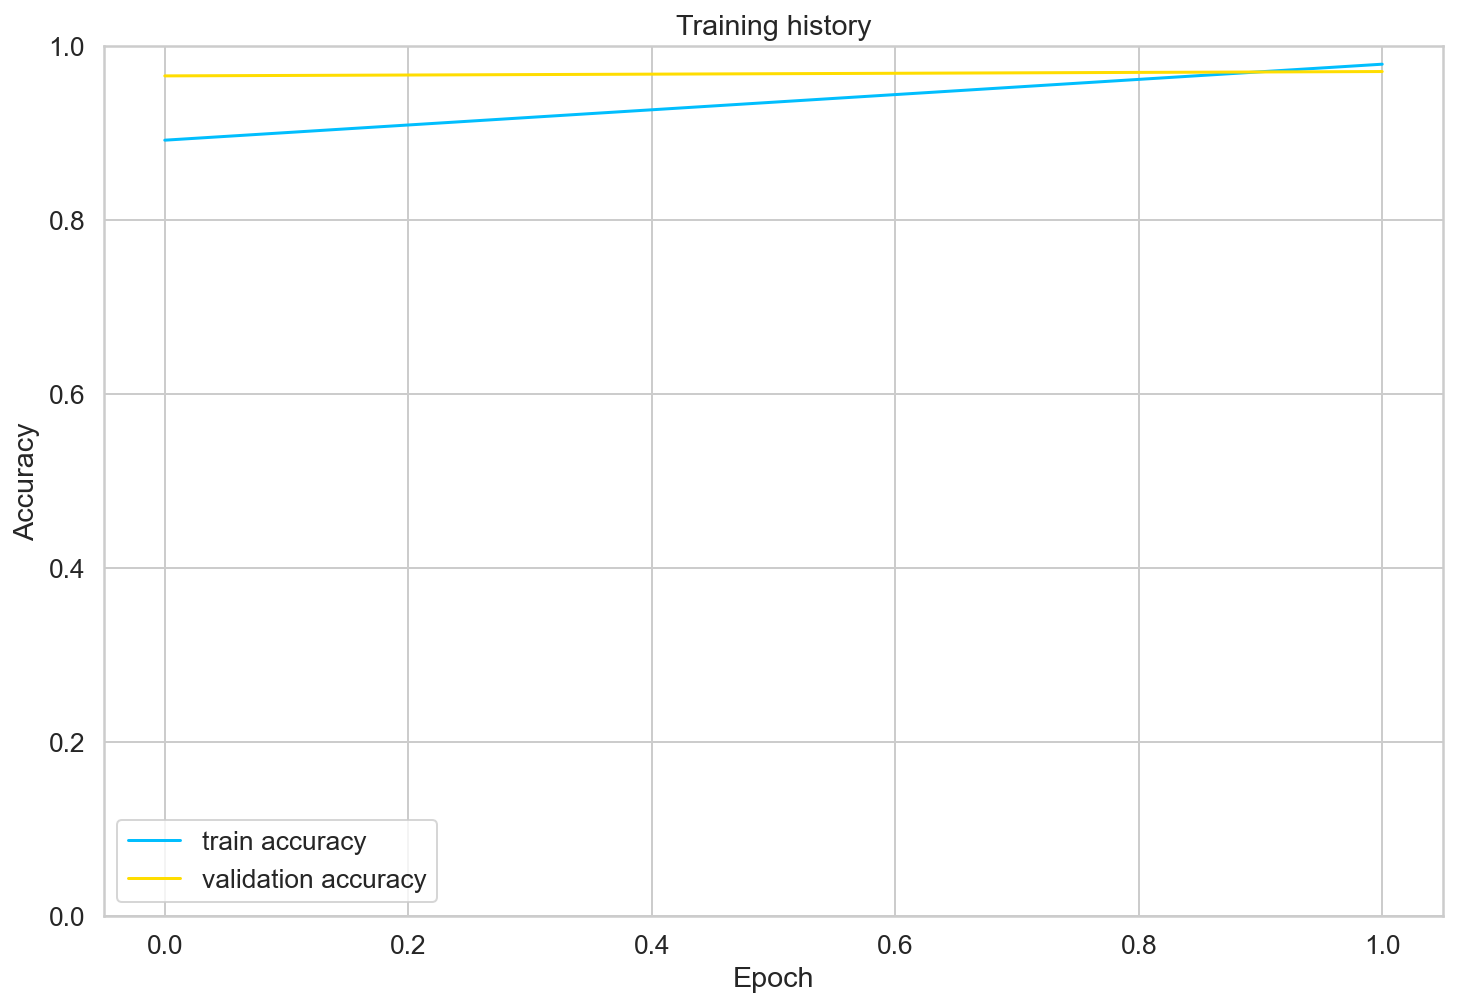

In [114]:
# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph charts
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

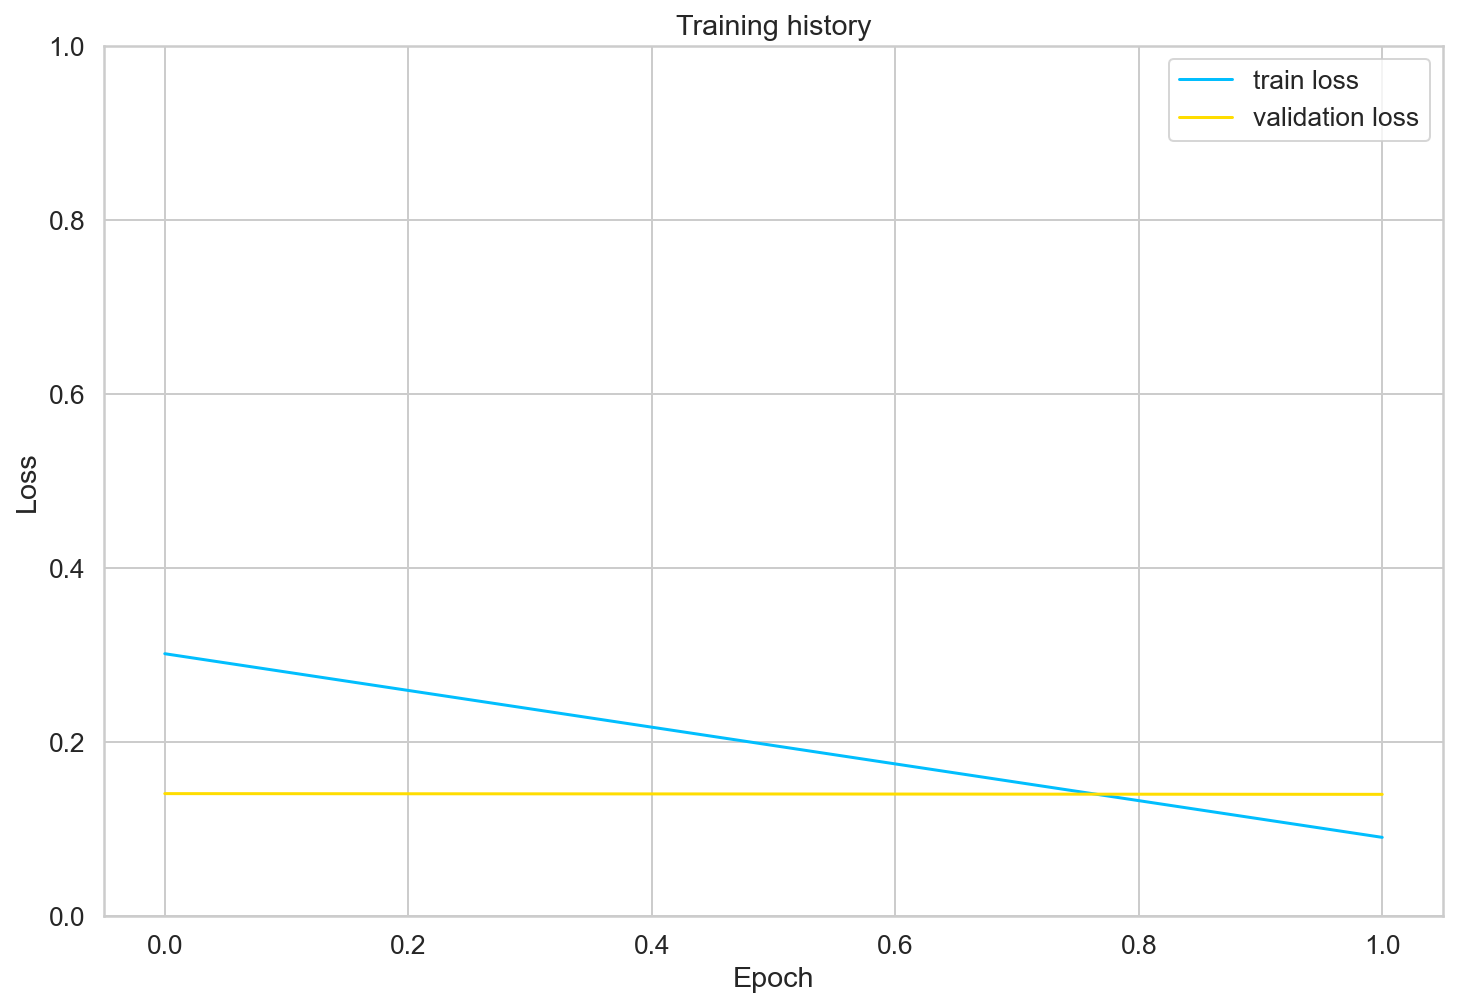

In [115]:
# Plot training and validation accuracy
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

# Graph chars
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [116]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
#     prediction_loss = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
#             loss = loss_fn(outputs, targets)
            

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
#             prediction_loss.extend()

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
#     prediction_loss = torch.stack(prediction_loss).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [117]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [118]:
class_names = ['neutral' , 'positive', 'negative']

In [119]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     neutral       0.97      0.98      0.98       813
    positive       0.98      0.98      0.98       843
    negative       0.96      0.94      0.95       342

    accuracy                           0.97      1998
   macro avg       0.97      0.97      0.97      1998
weighted avg       0.97      0.97      0.97      1998



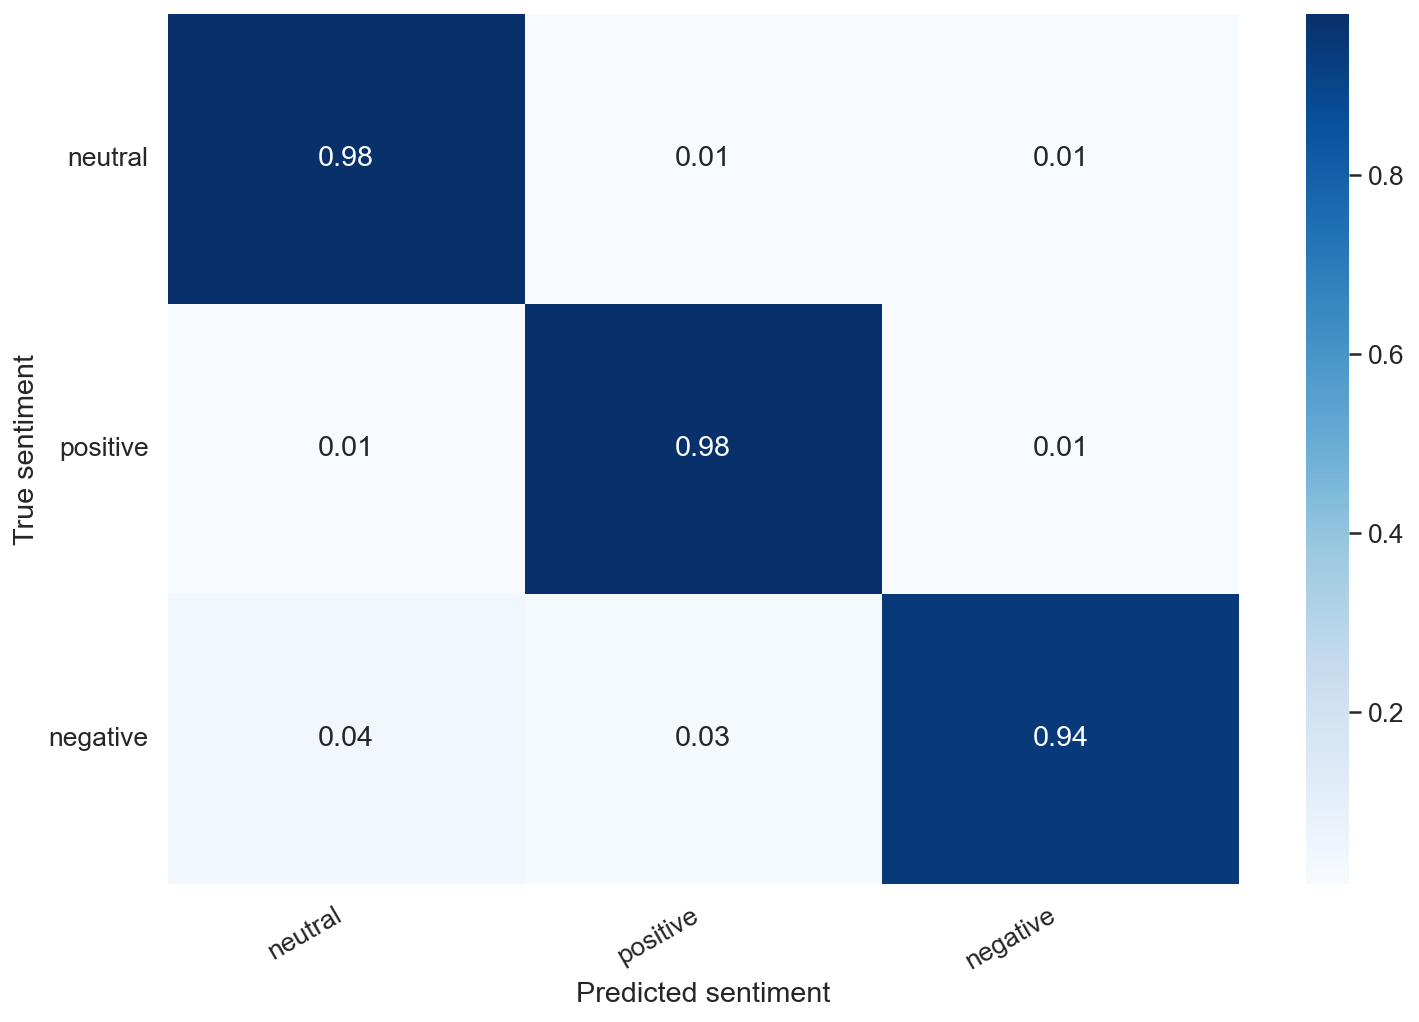

In [120]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap="Blues") #fmt='d' for digits, fmt='.2f' for float
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test.to("cpu").numpy(), y_pred.to("cpu").numpy())
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cmn, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [121]:
review_text = "Tesla announce superb earnings!"

In [122]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

C:\Users\danie\anaconda3\envs\new-env\lib\site-packages\transformers\tokenization_utils_base.py:2211: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [123]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Tesla announce superb earnings!
Sentiment  : positive


In [124]:
# Note even though this model seems to produce decent performance, its not trained on a large corpus of tweets.
# So if we take this model and predict on future tweets prospectively, we will very likely see a decay in model performance
# due to data drift.